# CIS 545 Final Project: Cryptocurrency Analysis and Exchange Rate Prediction

Edwin Castañeda, Nicholas Isaza, Caleb Pennington

## Section 0: Setting Up Data and Packages

### Importing Required Packages

In [1]:
! pip install seaborn

In [2]:
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import platform
import seaborn as sns
import statsmodels.api as sm
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# This magic command allows figures to be displayed in the notebook
%matplotlib inline 

# Uncomment this line if you want interactive matplotlib plot ()
# %matplotlib notebook 

# reloads modules automatically before entering the execution of code typed at
# the IPython prompt
%load_ext autoreload
%autoreload 2

### Mounting Google Drive

In [4]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
instruments_df = pd.read_csv(
    '/content/drive/MyDrive/data/instruments.csv')
exchanges_df = pd.read_csv(
    '/content/drive/MyDrive/data/exchanges.csv')
assets_df = pd.read_csv(
    '/content/drive/MyDrive/data/assets.csv')
non_crypto_df = pd.read_csv(
    '/content/drive/MyDrive/data/non_crypto_data.csv')
daily_price_df = pd.read_parquet(
    '/content/drive/MyDrive/data/daily_price.pq')
proj_crypto_arb_df = pd.read_parquet(
    '/content/drive/MyDrive/data/01_proj_crypto_arb_dp.pq')

### First Look at our Data

In [ ]:
print(instruments_df.shape, '\n')
print(instruments_df.dtypes, '\n')
print(instruments_df.head(5), '\n')
instruments_df

(29461, 14) 

kaiko_legacy_exchange_slug     object
trade_start_time               object
trade_end_time                 object
code                           object
exchange_code                  object
exchange_pair_code             object
base_asset                     object
quote_asset                    object
kaiko_legacy_symbol            object
trade_start_timestamp         float64
trade_end_timestamp           float64
trade_count                     int64
trade_compressed_size           int64
inst_class                     object
dtype: object 

  kaiko_legacy_exchange_slug  ... inst_class
0                         ab  ...       spot
1                         ab  ...       spot
2                         ab  ...       spot
3                         ab  ...       spot
4                         ab  ...       spot

[5 rows x 14 columns] 



,kaiko_legacy_exchange_slug,trade_start_time,trade_end_time,code,exchange_code,exchange_pair_code,base_asset,quote_asset,kaiko_legacy_symbol,trade_start_timestamp,trade_end_timestamp,trade_count,trade_compressed_size,inst_class
0,ab,2019-03-28 05:34:53+00:00,2019-06-17 09:09:29+00:00,bchabc-btc,abts,BCH_BTC,bchabc,btc,bchbtc,1.553751e+12,1.560763e+12,8666,222664,spot
1,ab,2019-03-28 19:22:07+00:00,2019-06-15 20:49:32+00:00,btc-doge,abts,BTC_DOGE,btc,doge,btcdoge,1.553801e+12,1.560632e+12,5358,138554,spot
2,ab,2018-09-26 01:07:12+00:00,2019-06-09 19:19:06+00:00,btg-btc,abts,BTG_BTC,btg,btc,btgbtc,1.537924e+12,1.560108e+12,1018,26015,spot
3,ab,2019-02-24 04:36:14+00:00,2019-06-06 16:19:31+00:00,dash-bchabc,abts,DASH_BCH,dash,bchabc,dashbch,1.550983e+12,1.559838e+12,2695,74290,spot
4,ab,2019-03-31 19:11:39+00:00,2019-06-17 09:54:53+00:00,dash-btc,abts,DASH_BTC,dash,btc,dashbtc,1.554059e+12,1.560765e+12,13183,339962,spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29456,zb,2019-03-05 15:27:34+00:00,NaN,zb-qc,zbcn,zb_qc,zb,qc,zbqc,1.551800e+12,NaN,295755450,2105890295,spot
29457,zb,2019-03-05 15:23:12+00:00,NaN,zb-usdt,zbcn,zb_usdt,zb,usdt,zbusdt,1.551799e+12,NaN,17875915,155429907,spot
29458,zb,2019-02-17 04:20:59+00:00,2020-05-10 13:43:09+00:00,zrx-btc,zbcn,zrx_btc,zrx,btc,zrxbtc,1.550377e+12,1.589118e+12,4289,55802,spot
29459,zb,2019-03-05 08:00:43+00:00,NaN,zrx-qc,zbcn,zrx_qc,zrx,qc,zrxqc,1.551773e+12,NaN,127824,1499913,spot


In [ ]:
print(exchanges_df.shape, '\n')
print(exchanges_df.dtypes, '\n')
print(exchanges_df.head(5), '\n')

(86, 3) 

exchange_code        object
exchange_name        object
kaiko_legacy_slug    object
dtype: object 

  exchange_code exchange_name kaiko_legacy_slug
0          abts       AnyBits                ab
1          acxi           ACX                ax
2          alcn       Allcoin                al
3          bbox         Bibox                bx
4          bcex          BCEX                yy 



In [ ]:
print(assets_df.shape, '\n')
print(assets_df.dtypes, '\n')
print(assets_df.head(5), '\n')

(3854, 4) 

asset_code       object
asset_name       object
asset_class_1    object
asset_class_2    object
dtype: object 

  asset_code    asset_name   asset_class_1 asset_class_2
0        007      007 coin  cryptocurrency           NaN
1      0xbtc     0xBitcoin  cryptocurrency           NaN
2       1337         Elite  cryptocurrency           NaN
3        18c  18C (ex 18T)  cryptocurrency           NaN
4        18t           18T  cryptocurrency           NaN 



In [ ]:
print(non_crypto_df.shape, '\n')
print(non_crypto_df.dtypes, '\n')
print(non_crypto_df.head(5), '\n')

(5366, 9) 

date                           object
rf                            float64
rm                            float64
smb                           float64
hml                           float64
oil_wti_price                 float64
gold_price                    float64
libor_3mo                     float64
equity_market_uncert_index    float64
dtype: object 

         date     rf     rm  ...  gold_price  libor_3mo  equity_market_uncert_index
0  1999-01-04  0.019 -0.209  ...      287.15    5.06031                      114.31
1  1999-01-05  0.019  1.081  ...      287.15    5.06031                       71.60
2  1999-01-06  0.019  2.081  ...      287.65    5.06031                       94.59
3  1999-01-07  0.019 -0.089  ...      289.95    5.05750                      209.23
4  1999-01-08  0.019  0.431  ...      290.90    5.03781                      119.98

[5 rows x 9 columns] 



In [ ]:
print(daily_price_df.shape, '\n')
print(daily_price_df.dtypes, '\n')
print(daily_price_df.head(5), '\n')

(4497240, 12) 

exchange                     object
symbol                       object
date                 datetime64[ns]
exchange_name                object
kaiko_legacy_slug            object
count                         int64
open                        float64
high                        float64
low                         float64
close                       float64
volume                      float64
vwap                        float64
dtype: object 

  exchange  symbol       date  ...     close      volume      vwap
0     abts  BCHBTC 2019-03-29  ...  0.041304  270.352835  0.041582
1     abts  BCHBTC 2019-03-30  ...  0.040560  265.134862  0.040888
2     abts  BCHBTC 2019-03-31  ...  0.041143  264.814644  0.040823
3     abts  BCHBTC 2019-04-01  ...  0.040443  258.387732  0.040527
4     abts  BCHBTC 2019-04-02  ...  0.046722  199.879960  0.041621

[5 rows x 12 columns] 



In [ ]:
print(proj_crypto_arb_df.shape, '\n')
print(proj_crypto_arb_df.dtypes, '\n')
print(proj_crypto_arb_df.head(5), '\n')

(693, 22) 

exchange                  object
exchange_name             object
date              datetime64[ns]
symbol                    object
close                    float64
volume                   float64
count                      int64
ret                      float64
ret_l1                   float64
rf                       float64
rm                       float64
oil_wti_price            float64
gold_price               float64
libor_3mo                float64
ret_oil                  float64
ret_gold                 float64
d_libor_3mo              float64
rm_l1                    float64
ret_oil_l1               float64
ret_gold_l1              float64
libor_3mo_l1             float64
d_libor_3mo_l1           float64
dtype: object 

  exchange exchange_name       date  ... ret_gold_l1  libor_3mo_l1  d_libor_3mo_l1
0     btmx        BitMEX 2018-08-08  ...    0.223205       234.144          -0.181
1     btmx        BitMEX 2018-08-09  ...   -0.230956       234.050          -0.0

## Section 1: Introduction

Stock market prediction has been a goal in the finance industry since the birth of trading. Even before the public stock market, people were occupied with predicting supply and demand of assets in order to profit as much as they could on a trade. However, there does exist some controversy around this idea. The Efficient Market Hypothesis, supported by many academics, states that the public market is perfectly, efficiently priced. In other words, the hypothesis claims that the price of an asset depends on the information available regarding that asset, and any new information is immediately reflected in an updated price. Several influential investors and academics, however, insist that this theory cannot be true, as some industries have built strong businesses and wealth over being able to predict the stock market better than others. Overall, we, too, believe that the stock market is not a complete random walk, and,  from our studies, we know that it is possible to find factors that help predict stock market returns.

In this project notebook, we use these ideas as the foundation for our analysis and focus on predicting the market exchange rates of cryptocurrencies. A cryptocurrency is a new form of currency that is completely digital and uses blockchain technology and other functions to have complete transparency, decentralization, and immutability. Cryptocurrency is a fairly new concept. The first, and most popular, cryptocurrrency is considered to be Bitcoin, invented in 2009. Now, in 2020, there are a total of over 4000 different types of cryptocurrencies, and they have all gotten relatively popular, as they are all traded on exchanges. Bitcoin, Ethereum, and Ripple are the most valued cryptocurrencies in today's market, totaling approximately 79.5%. of the cryptocurrency market. However, we will analyze a multitude of cryptocurrencies traded among a wide number of exchanges in our analysis.

Many investors have attempted to predict the exchange rates of cryptocurrencies in order to make a profit. The crypto market is very young, and many would speculate that there is still a lot of money to be made in trading crypto. For this reason, we decided to take on the challenge of predicting crypto exchange rates ourselves. Note, that there are three common methods of predicting rates. The first method is to conduct a fundamental analysis, which would involve a study of the cryptocurrencies themselves. The second method is to perform a technical analysis, which requires multiple time series tests on availabale data. The third method of prediction is machine learning, which has recently emerged as an extremely powerful tool for stock market rate prediction given the abundance of data available today. Machine learning, is the approach that we will take in attempting to predict cryptocurrency exchange rates. From the knowledge acquired in CIS 545 from Professor Zach Ives, we analyze a large set of cryptocurrency data, and, ultimately, look for valuable features which we may use in a machine learning model that predicts cryptocurrency exchange rates.

Table of Contents


> * Section 0: Setting Up Data and Packages
  * Importing Required Packages
  * Mounting Google Drive
  * First Look at Data
> * Section 1: Introduction
> * Section 2: Exploratory Data Analysis
   * Identifying Base and Quote Currencies in Daily Price Dataframe
   * Exploratory Data Analysis
> * Section 3: Searching for Arbitrage
   * Graph EDA
   * Graph Representation and Arbitrage Functions
   * Searching for Arbitrage
> * Section 4: Modeling
> * Section 5: Description of Challenges
> * Section 6: Future Direction



## Section 2: Exploratory Data Analysis

To begin our analysis, we will investigate and familiarize ourselves with the data that we are working with. For this project, we are using a total of six data sets. To summarize, 
 
1. instruments_df
  * exchange, asset, date and trade information
  * 29,461 rows, 14 columns
2. exchanges_df
  * map of exchange codes, exchange names, and kaiko legacy slug
  * 86 rows, 3 columns
3. assets_df
  * map of asset codes to asset names and asset classes
  * 3854 rows, 4 columns
4. non_crypto_df
  * price data on assets that are not cryptocurrencies
  * 5366 rows, 9 columns 
5. daily_price_df
  * standard trading information for 78 different cryptocurrencies
  * 4,497,240 rows, 12 columns
6. proj_crypto_arb_df
  * mix of exchange statistics and non-crypto asset prices
  * 693 rows, 22 columns

Our analysis will mostly focus on the Daily Price DataFrame (daily_price_df) and Non-Crypto Dataframe (non_crypto_df), as we aim to use these dataframes in order to see if there are similar price movements between different types of assets over time. Overall, we conducted the following EDA with the goal of better understanding our data and, more importantly, identifying features that we believe we can use to build an effective model to predict the exchange rate between Bitcoin and U.S. Dollars.

### Identifying Base and Quote Currencies in Daily Price DataFrame (daily_price_df)

Before doing any analysis on our dataset of exchange rates, we needed to make some modifications to the Daily Price DataFrame (daily_price_df). We observed earlier that this dataframe contains the majority of the data necessary for this project, as it holds all of the available exchange rates between pairs of currencies. The problem, however, is that the Daily Price DataFrame does not distinguish between base currencies and quote currencies for each given exchange rate and, instead, only offers a concatenated symbol to represent the two currencies. To fix this problem, we used the asset codes provided in the Assets DataFrame (assets_df) to separate the trade symbols provided in Daily Price DataFrame. By separating the symbols into two valid assets, we can distinguish between the base currency and quote currency of each trade. Our function for performing this operation and cleaning the Daily Price DataFrame is in the cell below.

In [7]:
# List of currency codes
currencies = assets_df['asset_code'].unique().tolist()

In [8]:
def separate_symbol(s):
  """Uses for-loop and dictionary to separate a symbol into two currencies.

    Parameters
    ----------
    s : str
        A trade symbol (a string of two asset codes concatenated together)

    Returns
    -------
    str
        a string of two cryptocurrency asset codes separated by a space " "
  """
  # Since the asset codes in assets_df are lowercase, but prices_df has
  # uppercase symbols, we will begin by lowercasing the symbol
  s = s.lower() 

  # Separate the symbol into two valid asset codes
  for i in range(len(s) + 1) :
    if (s[i:] in currencies and s[:i] in currencies) :
      return " ".join([s[:i], s[i:]])
  return None

In [9]:
# The list of all symbols from daily_price_df
symbols = pd.Series(daily_price_df['symbol'].\
                    unique().\
                    tolist())

# The list of all symbols separated into base and quote currencies by a space
separated_symbols = symbols.apply(separate_symbol).\
dropna().\
map(lambda x: x.upper())

# A dataframe mapping symbols to separated symbols
symbol_key_df = pd.DataFrame({'symbol': symbols,
                              'separated_symbols': separated_symbols}).\
                              dropna()

# Separate the symbols into two separate columns (base and quote assets)
symbol_key_df[['base_asset','quote_asset']] =\
symbol_key_df['separated_symbols'].\
apply(lambda x: pd.Series(str(x).split(" ")))

# Drop the separated symbols column, since we have created two separate columns
# for base and quote assets
symbol_key_df = symbol_key_df.drop(columns= ['separated_symbols'])

# Merge the separated symbols with daily_price_df on the 'symbol' column
cleaned_daily_price_df = daily_price_df.merge(symbol_key_df, on= 'symbol')

### Exploratory Data Analysis

Using the following two lines, we can determine the time period our data spans. We see that our data spans from July 17, 2010 to June 30, 2020.

In [ ]:
# The earliest date in our data
daily_price_df.date.min()

Timestamp('2010-07-17 00:00:00')

In [ ]:
# The latest date in our data
daily_price_df.date.max()

Timestamp('2020-06-30 00:00:00')


The following plot shows the increase in the number of cryptocurrencies and exchanges over the past decade. As shown in the graph, the drastic increase in interest regarding cryptocurrency shows the value of our project.


[]

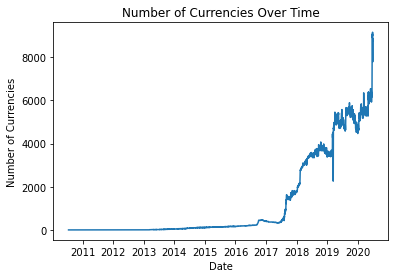

In [ ]:
# Count the number of currencies traded over time
x = daily_price_df.groupby('date')['symbol'].count()

# Plot the data
num_currencies = sns.lineplot(x= x.index, y= x)

# Add axes labels
num_currencies.set(xlabel = 'Date', ylabel = 'Number of Currencies')

# Add plot title
num_currencies.set_title('Number of Currencies Over Time')

# Show plot
num_currencies.plot()

Similar to the plot above, the following plot tracks the increase in the number of exchanges over time. 

[]

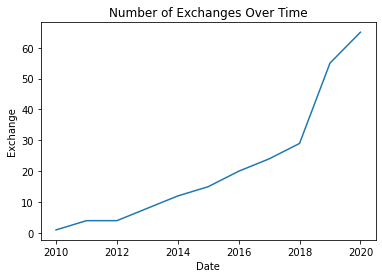

In [ ]:
# Count the number of exchanges active over time
x = cleaned_daily_price_df.\
groupby(cleaned_daily_price_df['date'].\
        dt.\
        year)['exchange'].\
        nunique()

# Plot the data
num_exchanges = sns.lineplot(x= x.index, y= x)

# Add axes labels
num_exchanges.set(xlabel = 'Date', ylabel = 'Exchange')

# Add plot title
num_exchanges.set_title('Number of Exchanges Over Time')

# Show plot
num_exchanges.plot()

Clearly the chart above shows a growth in popularity in cryptocurrency trading over the past few years. Perhaps analyzing data mostly from 2017 on will be most helpful as we move forward. 

Let's identify a few of the most popular exchanges for trading cryptocurrencies.

[]

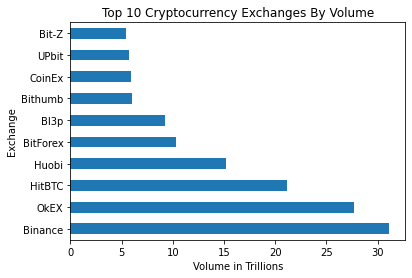

In [ ]:
# Calculate the total volume of each exchange
exchange_volume_bargraph = daily_price_df.\
groupby(['exchange_name'])['volume'].\
sum()

# Format values in trillions
exchange_volume_bargraph = exchange_volume_bargraph / 1000000000000

# Sort the exchanges from largest to smallest
exchange_volume_bargraph = exchange_volume_bargraph.\
sort_values(ascending= False)

# Extract the top ten largest exchanges
exchange_volume_bargraph = exchange_volume_bargraph.head(10)

# Plot a bar graph of the largest exchanges
exch_plot = exchange_volume_bargraph.plot(kind='barh')

# Set axes labels and title
exch_plot.set(xlabel= 'Volume in Trillions', ylabel= 'Exchange',
              title= 'Top 10 Cryptocurrency Exchanges By Volume')

# Show plot
exch_plot.plot()

We can consider the bar graph above, along with some other factors such as number of unique currencies traded to determine what exchanges will be most valuable to consider in further depth.

Let's track the value over time of a few of the most well-known cryptocurrencies on the market in one of the most popular cryptocurrency exchange, HitBTC.

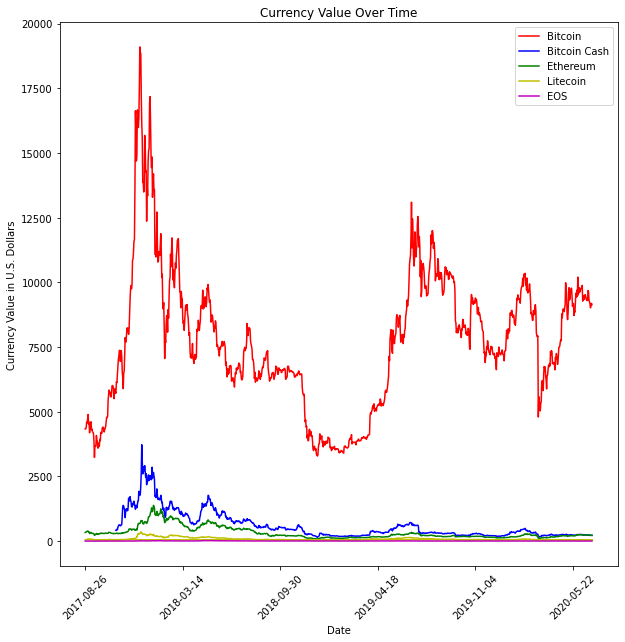

In [ ]:
#Access prices for Bitcoin
bitcoin_values_df = cleaned_daily_price_df.\
loc[(cleaned_daily_price_df.exchange  == 'hitb') &\
    (cleaned_daily_price_df.symbol  == 'BTCUSD')]
bitcoin_values_df = bitcoin_values_df.reset_index()
bitcoin_values_df['date'] = bitcoin_values_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))

#Access prices for Bitcoin Cash
bch_values_df = cleaned_daily_price_df.\
loc[(cleaned_daily_price_df.exchange  == 'hitb') &\
    (cleaned_daily_price_df.symbol  == 'BCHUSD')]
bch_values_df = bch_values_df.reset_index()
bch_values_df['date'] = bch_values_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))

#Access prices for Ethereuem 
ethereum_values_df = cleaned_daily_price_df.\
loc[(cleaned_daily_price_df.exchange  == 'hitb') &\
    (cleaned_daily_price_df.symbol  == 'ETHUSD')]
ethereum_values_df = ethereum_values_df.reset_index()
ethereum_values_df['date'] = ethereum_values_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))

#Access prices for LiteCoin
litecoin_values_df = cleaned_daily_price_df.\
loc[(cleaned_daily_price_df.exchange  == 'hitb') &\
    (cleaned_daily_price_df.symbol  == 'LTCUSD')]
litecoin_values_df = litecoin_values_df.reset_index()
litecoin_values_df['date'] = litecoin_values_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))

#Access prices for EOS
eos_values_df = cleaned_daily_price_df.\
loc[(cleaned_daily_price_df.exchange  == 'hitb') &\
    (cleaned_daily_price_df.symbol  == 'EOSUSD')]
eos_values_df = eos_values_df.reset_index()
eos_values_df['date'] = eos_values_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))

# Set plot size
plt.figure(figsize=(10, 10))
# Plot Bitcoin to USD rates
plt.plot(bitcoin_values_df['date'],
         bitcoin_values_df['close'], 
         'r-',
         label= 'Bitcoin')

# Plot Bitcoin Cash to USD rates
plt.plot(bch_values_df['date'],
         bch_values_df['close'],
         'b-',
         label= 'Bitcoin Cash')

# Plot Ethereum to USD rates
plt.plot(ethereum_values_df['date'],
         ethereum_values_df['close'],
         'g-',
         label= 'Ethereum')

# Plot Litecoin to USD rates
plt.plot(litecoin_values_df['date'],
         litecoin_values_df['close'],
         'y-',
         label= 'Litecoin')

# Plot EOS to USD rates
plt.plot(eos_values_df['date'],
         eos_values_df['close'],
         'm-',
         label= 'EOS')

# Add plot elements
plt.title('Currency Value Over Time') # Add plot title
plt.xlabel('Date') # Add x-axis label
plt.ylabel('Currency Value in U.S. Dollars') # Add y-axis label
plt.legend() # Add legend
plt.gca().\
axes.xaxis.set_major_locator(plt.MaxNLocator(6)) # Limit x-axis ticks to 6 ticks
plt.xticks(rotation= 45) # Rotate x-axis ticks 45 degrees
plt.show() # Show plot

It is interesting to note slight correlation between the behavior of the currencies. For example, look at the spike that occurs around early 2018 for all five currencies. It may be worth reading up on events occuring around that period to may speculate on what may have caused this behavior.

Looking at the visualization above, it confirms significant differences in scale between the currencies; Bitcoin is absoutely giant compared to the other currencies. Let's plot each of these smaller currencies individually to get a better understanding of their volatility. 

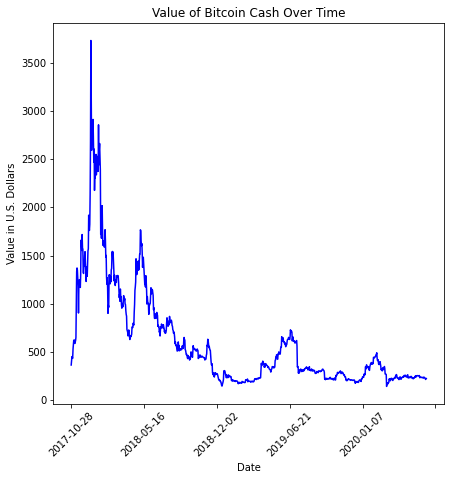

In [ ]:
# Set plot size
plt.figure(figsize=(7, 7))

# Plot Bitcoin to USD rates
plt.plot(bch_values_df['date'],
         bch_values_df['close'],
         'b-',
         label= 'Bitcoin Cash')

# Add plot elements
plt.title("Value of Bitcoin Cash Over Time") # Add plot title
plt.xlabel('Date') # Add x-axis label
plt.ylabel('Value in U.S. Dollars') # Add y-axis label
plt.gca().\
axes.xaxis.set_major_locator(plt.MaxNLocator(6)) # Limit x-axis ticks to 6 ticks
plt.xticks(rotation= 45) # Rotate x-axis ticks 45 degrees
plt.show() # Show plot

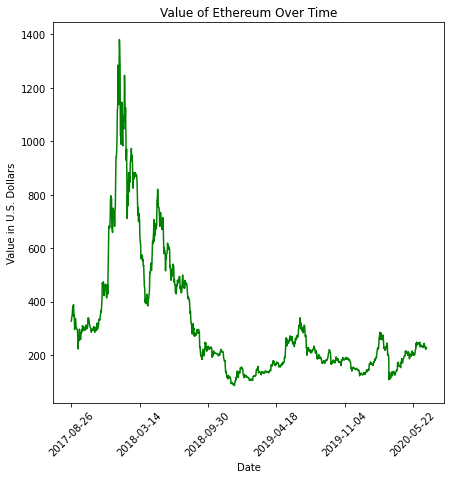

In [ ]:
# Set plot size
plt.figure(figsize=(7, 7))

# Plot Ethereum to USD rates
plt.plot(ethereum_values_df['date'],
         ethereum_values_df['close'],
         'g-',
         label= 'Ethereum')

# Add plot elements
plt.title("Value of Ethereum Over Time") # Add plot title
plt.xlabel('Date') # Add x-axis label
plt.ylabel('Value in U.S. Dollars') # Add y-axis label
plt.gca().\
axes.xaxis.set_major_locator(plt.MaxNLocator(6)) # Limit x-axis ticks to 6 ticks
plt.xticks(rotation= 45) # Rotate x-axis ticks 45 degrees
plt.show() # Show plot

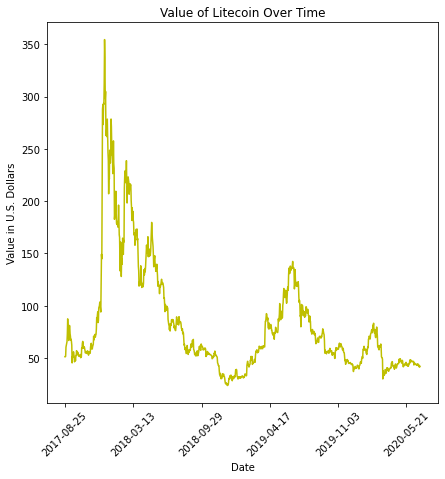

In [ ]:
# Set plot size
plt.figure(figsize=(7, 7))

# Plot Litecoin to USD rates
plt.plot(litecoin_values_df['date'],
         litecoin_values_df['close'],
         'y-',
         label= 'Litecoin')

# Add plot elements
plt.title("Value of Litecoin Over Time") # Add plot title
plt.xlabel('Date') # Add x-axis label
plt.ylabel('Value in U.S. Dollars') # Add y-axis label
plt.gca().\
axes.xaxis.set_major_locator(plt.MaxNLocator(6)) # Limit x-axis ticks to 6 ticks
plt.xticks(rotation= 45) # Rotate x-axis ticks 45 degrees
plt.show() # Show plot

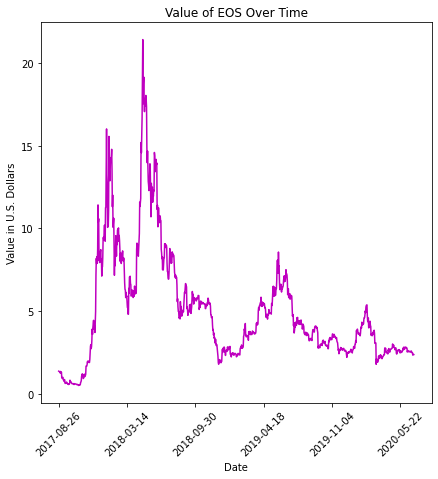

In [ ]:
# Set plot size
plt.figure(figsize=(7, 7))

# Plot EOS to USD rates
plt.plot(eos_values_df['date'],
         eos_values_df['close'],
         'm-',
         label= 'EOS')

# Add plot elements
plt.title("Value of EOS Over Time") # Add plot title
plt.xlabel('Date') # Add x-axis label
plt.ylabel('Value in U.S. Dollars') # Add y-axis label
plt.gca().\
axes.xaxis.set_major_locator(plt.MaxNLocator(6)) # Limit x-axis ticks to 6 ticks
plt.xticks(rotation= 45) # Rotate x-axis ticks 45 degrees
plt.show() # Show plot

Visual analysis of the major currencies above individually further supports our initial claim that the movement of individual currencies correlate heavily with one another. All five major currencies follow very similar shapes, displaying peaks and valleys of relatively similar size in the same places (to scale depending on the value of the currency). We can gain a more technical understanding of the correlation between these cryptocurrencies by examining a correlation heat map between cryptocurrencies. 

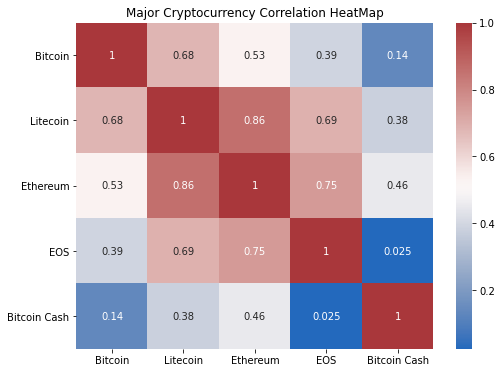

In [ ]:
# Initialize the correlation DataFrame
correlation_df = pd.DataFrame()

# Add Bitcoin to USD rates
correlation_df['Bitcoin'] = bitcoin_values_df['close']

# Add Litecoin to USD rates
correlation_df['Litecoin'] = litecoin_values_df['close']

# Add Ethereum to USD rates
correlation_df['Ethereum'] = ethereum_values_df['close']

# Add EOS to USD rates
correlation_df['EOS'] = eos_values_df['close']

# Add Bitcoin Cash to USD rates
correlation_df['Bitcoin Cash'] = bch_values_df['close']

#Calculate the correlation between exchange rates
corr = correlation_df.corr()

# Plot the data
plt.figure(figsize=(8, 6)) # set figure size
plt.title('Major Cryptocurrency Correlation HeatMap') # add plot title
hm = sns.heatmap(corr, annot= True, cmap='vlag') # format data in heatmap
hm.set_yticklabels(labels=['Bitcoin',
                           'Litecoin', 
                           'Ethereum',
                           'EOS',
                           'Bitcoin Cash'],
                   rotation=360) # add y-axis labels
plt.show() # show plot

It looks like our intuition was correct for some cryptocurrencies but incorrect for others. For example, there is very strong correlation between the price of Ethereum and the price of Litecoin, but almost nonexistent correlation between the price of EOS and the price of Bitcoin Cash.

Let's look into some of our other data sets to see if we can find other financial data the may be potential influences for cryptocurrency exchange rate behavior. Here, we'll analyze some common indicators of financial welfare such as a U.S. risk-free rate of return index, a U.S. market return index, the small minus big (smb) factor from the Fama/French stock pricing model, the high minus low (hml) factor from the Fama/French stock pricing model, oil price, gold price, 3-Month LIBOR, and the Equity Market Uncertainty Index. In order to provide information relative to the major cryptocurrency graphs above, we will limit the data to the indexes occuring after September 2017.

In [ ]:
# Create the DataFrame for non-crypto financial indexes
financial_indicators_df = non_crypto_df.copy()

# Filter the data frame to only view data after September, 2017
financial_indicators_df = financial_indicators_df[
                          pd.to_datetime(financial_indicators_df.date) 
                          >= datetime(2017, 9, 1)]

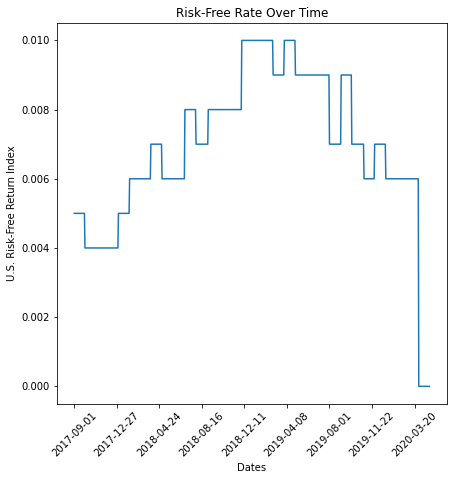

In [ ]:
# Time series plot of a risk-free rate index
plt.figure(figsize= (7, 7)) # Set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.rf)

plt.gca().axes\
.xaxis.set_major_locator(plt.MaxNLocator(11)) # Limit x-axis ticks to 9 ticks

plt.xticks(rotation= 45) # rotate x-axis tick marks 45 degrees

plt.xlabel('Dates') # add x-axis label
plt.ylabel('U.S. Risk-Free Return Index') # add y-axis label
plt.title('Risk-Free Rate Over Time') # add title

plt.show() # show plot

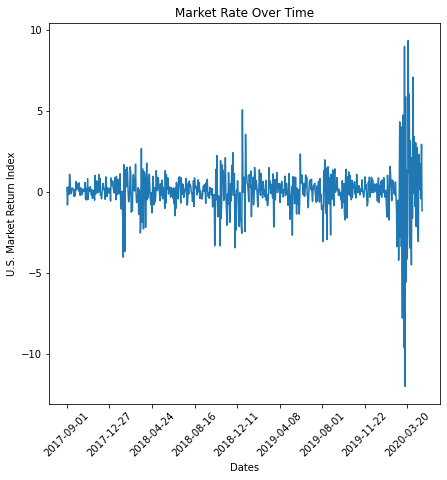

In [ ]:
# time series plot of U.S. Market Return Index over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.rm)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('U.S. Market Return Index') # add y-label
plt.title('Market Rate Over Time') # add title

plt.show() # show plot

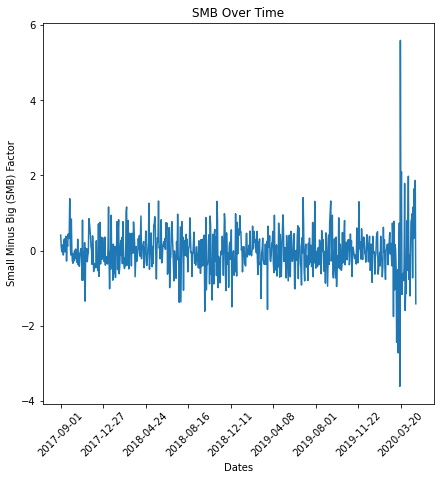

In [ ]:
# time series plot of Small Minus Big Index over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.smb)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('Small Minus Big (SMB) Factor') # add y-label
plt.title('SMB Over Time') # add title

plt.show() # show plot

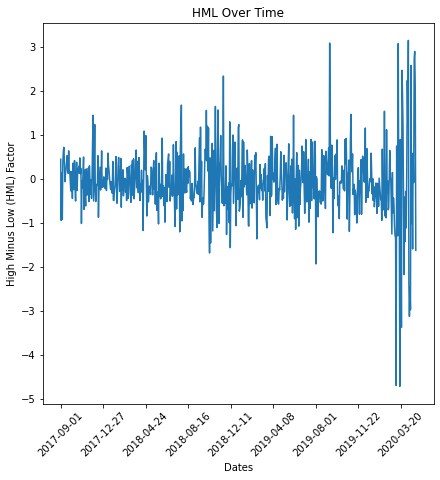

In [ ]:
# time series plot of High Minus Low Index over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.hml)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('High Minus Low (HML) Factor') # add y-label
plt.title('HML Over Time') # add title

plt.show() # show plot

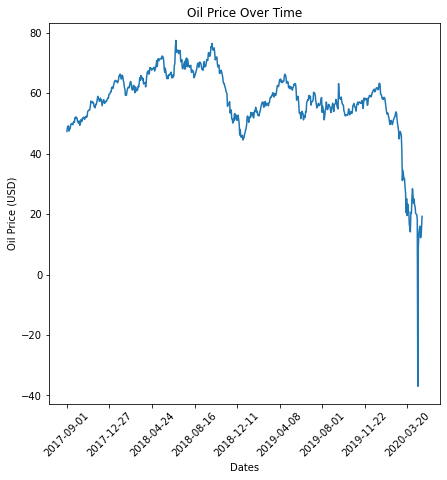

In [ ]:
# time series plot of West Texas Index Oil Price over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.oil_wti_price)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('Oil Price (USD)') # add y-label
plt.title('Oil Price Over Time') # add title

plt.show() # show plot

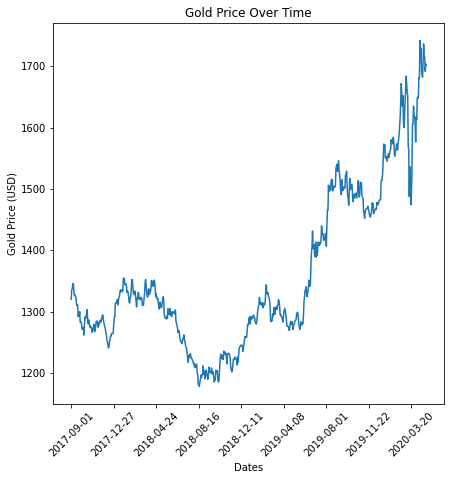

In [ ]:
# time series plot of Gold Price over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.gold_price)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('Gold Price (USD)') # add y-label
plt.title('Gold Price Over Time') # add title

plt.show() # show plot

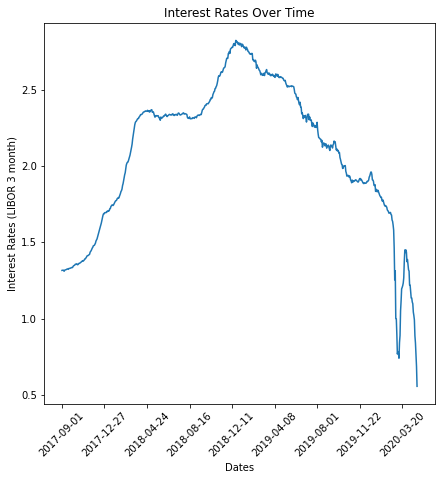

In [ ]:
# time series plot of London Inter-Bank Offered Rate (LIBOR 3month) over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.libor_3mo)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('Interest Rates (LIBOR 3 month)') # add y-label
plt.title('Interest Rates Over Time') # add title

plt.show() # show plot

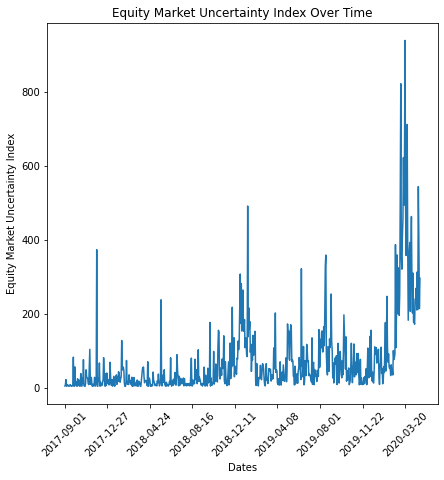

In [ ]:
# time series plot of Equity Market Uncertainty Index over time
plt.figure(figsize= (7, 7)) # set figure size

plt.plot(financial_indicators_df.date, # plot time series
         financial_indicators_df.equity_market_uncert_index)

# limit plot size to 9 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(11)) 

# rotate x-ticks so dates are legible
plt.xticks(rotation= 45)

plt.xlabel('Dates') # add x-label
plt.ylabel('Equity Market Uncertainty Index') # add y-label
plt.title('Equity Market Uncertainty Index Over Time') # add title

plt.show() # show plot

As we can see, it is much more difficult to determine similar movements over time for the financial indicators above than it was for the plots of currency exchange rates. While the shapes of the financial indicators do not exactly appear to be very similar, we would still like to get a sense of the relationship between these indicators cryptocurrency exchange rates. Again, we will observe a correlation heat map between cryptocurrencies and add the financial indicators we examined above. 

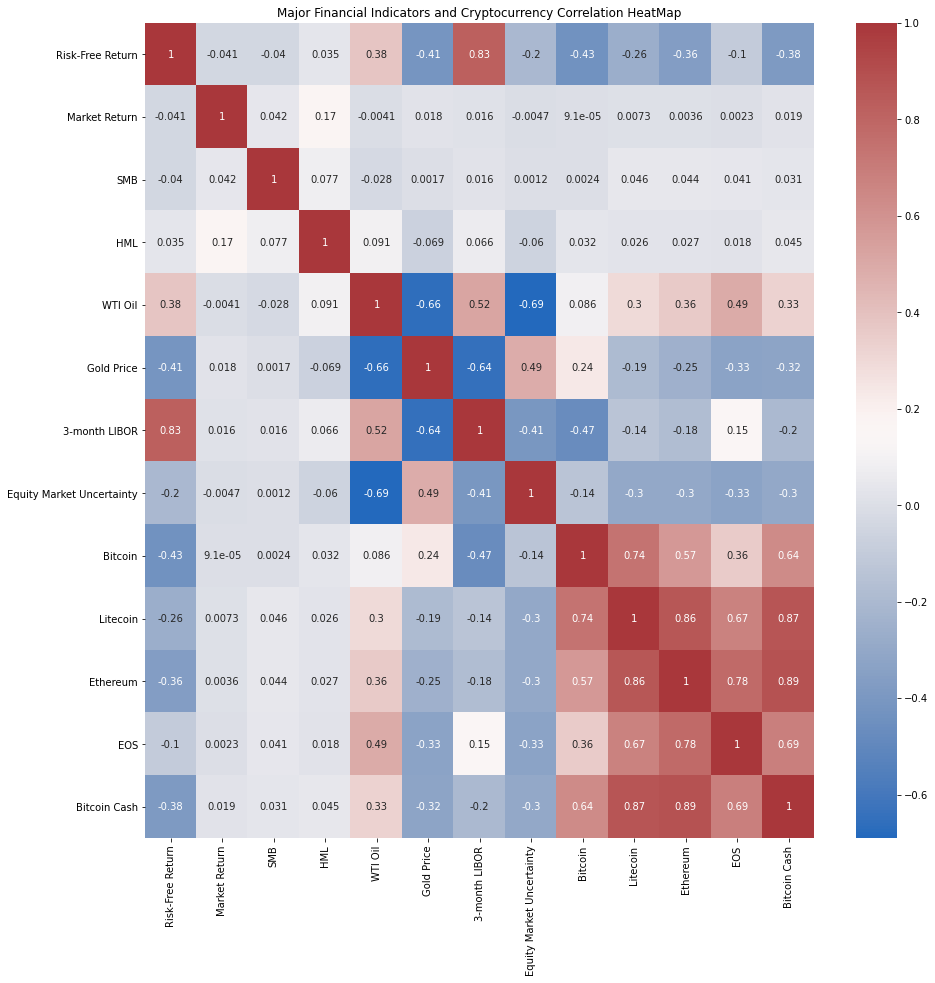

In [ ]:
# Put major cryptocurrencies and non_crypto financial indicators into one 
# dataframe to build a correlation matrix
df = financial_indicators_df.merge(
    bitcoin_values_df, on= 'date').rename(
        columns={'close': 'bit'}).merge(
            litecoin_values_df, on= 'date').rename(
                columns={'close': 'lite'}).merge(
                    ethereum_values_df, on= 'date').rename(
                        columns={'close': 'eth'}).merge(
                            eos_values_df, on= 'date').rename(
                                columns={'close': 'eos'}).merge(
                                    bch_values_df, on= 'date').rename(
                                        columns={'close': 'bch'})
                                    
# Rename each of the commodities indicators to a clearer name for visualization
correlation_df = pd.DataFrame()
correlation_df['Risk-Free Return'] = df['rf']
correlation_df['Market Return'] = df['rm']
correlation_df['SMB'] = df['smb']
correlation_df['HML'] = df['hml']
correlation_df['WTI Oil'] = df['oil_wti_price']
correlation_df['Gold Price'] = df['gold_price']
correlation_df['3-month LIBOR'] = df['libor_3mo']
correlation_df['Equity Market Uncertainty'] = df['equity_market_uncert_index']
correlation_df['Bitcoin'] = df['bit']
correlation_df['Litecoin'] = df['lite']
correlation_df['Ethereum'] = df['eth']
correlation_df['EOS'] = df['eos']
correlation_df['Bitcoin Cash'] = df['bch']

corr = correlation_df.corr() # calculate correlation between data

# Create and name correlation matrix
f = plt.figure(figsize=(15, 15))
plt.title('Major Financial Indicators and Cryptocurrency Correlation HeatMap')
hm = sns.heatmap(corr, annot= True, cmap='vlag')

# Reset y-ticks from default to match x-ticks so correlation matrix can be
# more easily read
hm.set_yticklabels(labels=['Risk-Free Return', 'Market Return',
                           'SMB', 'HML', 'WTI Oil', 'Gold Price',
                           '3-month LIBOR', 'Equity Market Uncertainty',
                           'Bitcoin', 'Litecoin', 
                           'Ethereum', 'EOS', 'Bitcoin Cash'], rotation=360)

plt.show() # show correlation matrix

The correlation heat map suggests that there is not a strong relationship between financial indicators and the price of cryptocurrencies. This is not the result that we were expecting, as we would have liked to uncover more reasoning behind the price movements of cryptocurrencies. We will keep this in mind moving forward, as we build a model to predict the exchange rate of Bitcoin to U.S. Dollars.

## Section 3: Searching For Arbitrage Using Graph Algorithms

In this portion of our project, we attempt to detect arbitrage opportunities in cryptocurrency trades on specific dates by representing our data as a graph and determining the shortest path between two nodes.

We begin by modeling our exchange rate data as a graph where nodes are the cryptocurrencies and the edges between nodes are the exchange rates. Once we organize our dataframe into a graph representation, we can detect arbitrage by searching for paths whose product of edges is greater than one. 

We ran a for-loop to find arbitrage examples only between the dates of March 29, 2019 and April 19, 2019 due to time constraints. However, we did successfully find several arbitrage opportunities in the data. Interestingly, it seemed that both EXX and Bittrex exchanges frequently present arbitrage opportunities.

Arbitrage Opportunities:
* OkCoin on 2019-03-29
* EXX from March 30th to April 10th, 2019 (excluding April 5th and 8th), April 16th, 2019, and April 19th, 2019
* Bittrex from March 31st to April 19th, 2019 (excluding April 1st)

In conclusion, we found that a larger graph representation size does not suggest an exchange is more likely to present arbitrage.


### Graph EDA

Before searching for arbitrage, we thought it may be interesting to perform some EDA and see how much data each exchange offers in our dataset. We begin by first looking at the number of unique currencies traded on each exchange. Our results are shown in the plots below. 

Without having full implementation of our graphing algorithm, we can begin to look for inefficiencies in the crypto market and estimate any predictors. Specifically, we will define these inefficiencies by the mean standard deviation of closing prices for a given symbol on a given day. Our hypothesis suggests that possible predictors are liquidity, price volatility, and exchange access (how many exchanges the symbol trades on). Below we test these predictors using OLS regression.

In [ ]:
#Y-var: Mean standard deviation of closing prices for a given symbol on a given day 
#Proxy for inefficienices (arbitrage opportunities) by symbol
price_disc = daily_price_df.groupby(['symbol', 'date'])['close'].std()
price_disc = price_disc.groupby('symbol').mean()

#Predictor: Degree of movement in closing prices for a given symbol
price_volatility = daily_price_df.groupby('symbol')['close'].std()

#Predictor: The number of exchanges that a given symbol trades on
exchange_access = daily_price_df.groupby('symbol')['exchange'].nunique()

#Forming new dataframe with predictors and Y-var
dfx = pd.DataFrame({'price_disc':price_disc, 'price_volatility':price_volatility, 'exchange_access': exchange_access})

In [ ]:
#Normalizing volatility measure and cleaning data
dfx['l_volatility'] = dfx['price_volatility'].apply(lambda x: np.log(x))
dfx['l_volatility'] = dfx['l_volatility'].replace(np.inf, np.nan).replace(-np.inf, np.nan)

dfx = dfx.dropna()

In [ ]:
#Run regression to find determinants
xvars = sm.add_constant(dfx[['l_volatility', 'exchange_access']])
yvar = dfx['price_disc']
res = sm.OLS(yvar, xvars).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_disc   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     38.83
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.28e-17
Time:                        23:10:01   Log-Likelihood:                -24912.
No. Observations:                1678   AIC:                         4.983e+04
Df Residuals:                    1675   BIC:                         4.985e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.226e+05   2.97e+04      4.125      0.000    6.43e+04    1.81e+05
l_volatility     2.006e+04   2516.305      7.971      0.000    1.51e+04     2.5e+04
exchange_access  1.114e+04   4130.473      2.697      0.007    3037.399    1.92e+04
==============================================================================
Omnibus:                     4234.096   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         51216951.184
Skew:                          26.655   Prob(JB):                         0.00
Kurtosis:                     857.225   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the results suggests, our log volatility measure has a statistically significant effect on price discrepancy. The implication here is that symbols with frequent, large price changes tend to have a greater degree of mispricing. Below we consider a regression using solely the log volatility measure. 




In [ ]:
xvars = sm.add_constant(dfx[['l_volatility']])
yvar = dfx['price_disc']
res = sm.OLS(yvar, xvars).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_disc   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     70.12
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.16e-16
Time:                        23:10:01   Log-Likelihood:                -24916.
No. Observations:                1678   AIC:                         4.984e+04
Df Residuals:                    1676   BIC:                         4.985e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.737e+05   2.29e+04      7.572      0.000    1.29e+05    2.19e+05
l_volatility  2.093e+04   2499.890      8.374      0.000     1.6e+04    2.58e+04
==============================================================================
Omnibus:                     4260.363   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         53720249.968
Skew:                          27.066   Prob(JB):                         0.00
Kurtosis:                     877.881   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, we see that a symbol's log volatility has a significant effect on its degree of mispricing. We also note that the regression's strength (defined by r-squared) is somewhat improved with the exchange access variable. Mispricings in the crypto market are generally attributed to transaction costs involved in moving money in and out of exchanges. The positive effect of our exchange_access variable on the regression is aligned with this hypothesis.

We also took a more visual approach so that we could observe how much graph data we would be able to construct from our dataset.

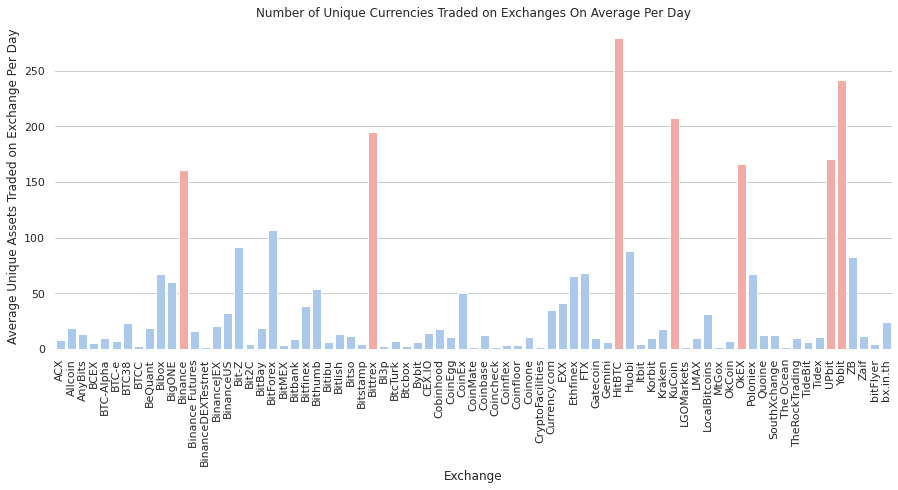

In [ ]:
# In this cell, we will investigate the average number of unique currencies
# traded on each exchange on each day

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
unique_currencies = cleaned_daily_price_df[['date',
                                            'exchange_name',
                                            'base_asset']].rename(
    columns= {'exchange_name' : 'Exchange',
              'base_asset' : 'Asset'}).append(
        cleaned_daily_price_df[['date',
                                'exchange_name',
                                'quote_asset']].rename(
    columns= {'exchange_name' : 'Exchange',
              'quote_asset' : 'Asset'})
).groupby(['date', 'Exchange'])['Asset'].nunique().groupby('Exchange').mean()

# Plot the number of unique currencies per exchange
clrs = ['b' if (x < 150) else 'r' for x in unique_currencies]
g= sns.barplot(x= unique_currencies.index,
               y= unique_currencies.values,
               palette= clrs)

# Add axis labels
ax.set(title= 'Number of Unique Currencies Traded on Exchanges On Average Per Day',
       ylabel="Average Unique Assets Traded on Exchange Per Day",
       xlabel="Exchange")
g.set_xticklabels(labels= unique_currencies.index,
                  rotation=90)

sns.despine(left=True, bottom=True)

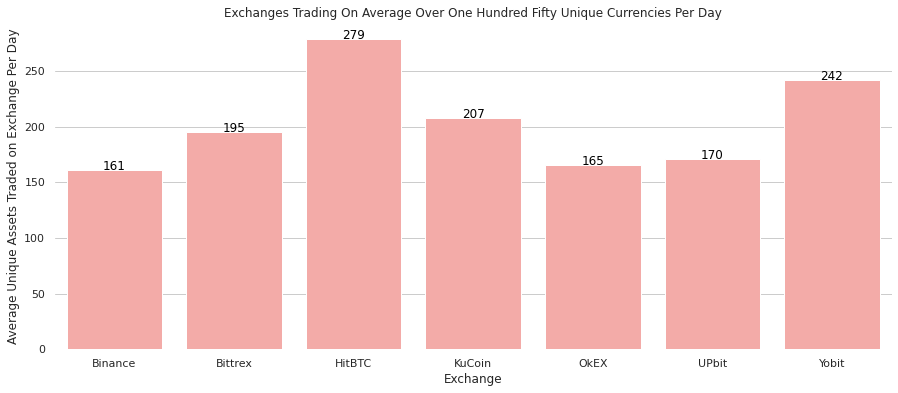

In [ ]:
# In this cell, we take a closer look at the exchanges with the most number of
# unique currencies traded

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
most_unique_currencies = unique_currencies.where(
    unique_currencies >= 150).dropna()

# Plot the total crashes
g= sns.barplot(x= most_unique_currencies.index,
                                   y= most_unique_currencies.values,
                                   color= 'r')

# Add axis labels
ax.set(title= 'Exchanges Trading On Average Over One Hundred Fifty Unique Currencies Per Day',
       ylabel="Average Unique Assets Traded on Exchange Per Day",
       xlabel="Exchange")
g.set_xticklabels(labels= most_unique_currencies.index)

# Add bar measurements
for i in range(len(most_unique_currencies)):
    g.text(i,
           most_unique_currencies[i],
           s= int(most_unique_currencies[i]),
           color='black',
           ha="center")
    
sns.despine(left=True, bottom=True)

The plots denoting the average number of unique currencies traded helps us understand the approximate number of nodes each exchange has in its graph representation. However, in order to detect arbitrage, we also need edges, which is precisely the next EDA analysis perfomed below.

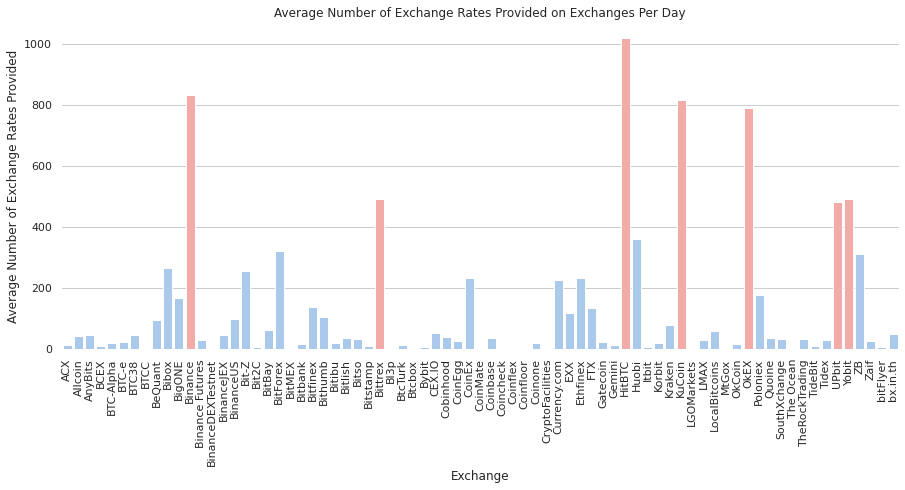

In [ ]:
# In this cell, we will investigate the average number of exchange rates
# provided on each exchange on each day

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
trades = cleaned_daily_price_df[['date',
                        'exchange_name',
                        'base_asset']].rename(
    columns= {'exchange_name' : 'Exchange',
              'base_asset' : 'Asset'}).append(
        cleaned_daily_price_df[['date',
                                'exchange_name',
                                'quote_asset']].rename(
    columns= {'exchange_name' : 'Exchange',
              'quote_asset' : 'Asset'})
).groupby(['date', 'Exchange'])['Exchange'].count().groupby('Exchange').mean()

# Plot the number of unique currencies per exchange
clrs = ['b' if (x < 400) else 'r' for x in trades]
g= sns.barplot(x= trades.index,
               y= trades.values,
               palette= clrs)

# Add axis labels
ax.set(title= 'Average Number of Exchange Rates Provided on Exchanges Per Day',
       ylabel="Average Number of Exchange Rates Provided",
       xlabel="Exchange")
g.set_xticklabels(labels= trades.index,
                  rotation=90)

sns.despine(left=True, bottom=True)

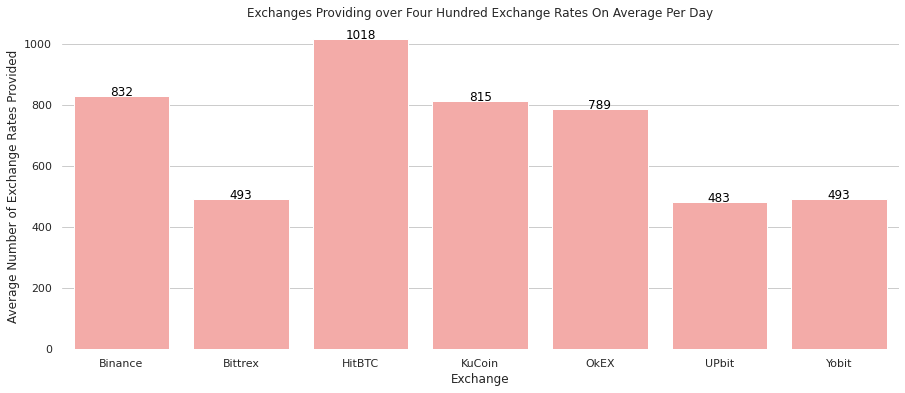

In [ ]:
# In this cell, we take a closer look at the exchanges that offer the most
# exchange rate data per day

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
most_trades = trades.where(
    unique_currencies >= 150).dropna()

# Plot the total crashes
g= sns.barplot(x= most_trades.index,
                                   y= most_trades.values,
                                   color= 'r')

# Add axis labels
ax.set(title= 'Exchanges Providing over Four Hundred Exchange Rates On Average Per Day',
       ylabel="Average Number of Exchange Rates Provided",
       xlabel="Exchange")
g.set_xticklabels(labels= most_trades.index)

# Add bar measurements
for i in range(len(most_trades)):
    g.text(i,
           most_trades[i],
           s= int(most_trades[i]),
           color='black',
           ha="center")
    
sns.despine(left=True, bottom=True)

Interestingly, the same exchanges that trade the most number of unique currencies, also provide the largest number of exchange rates. Out of all of the exchanges, we expect that these seven exchanges with the largest graph representations are the most likely exchanges to provide arbitrage opportunities.

The last EDA we think is interesting to assess is the "completeness" of the graph representation of each exchange. In the context of our project, an exchange trading $n$ currencies should provide $n^2 - n$ exchange rates (two between every pair of nodes) in order to have a complete graph representation. We have plotted the analysis below, although it is much less meaningful than the plots above, since it seems the most complete graphs happen to be most complete due to a lack of data for those exchanges. We also looked at the completeness of the seven exchanges with the largest graph representation.

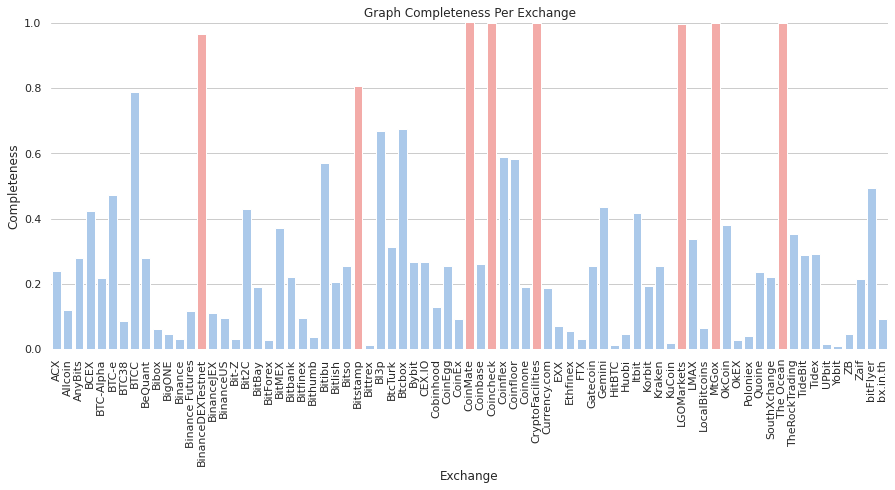

In [ ]:
# In this cell, we combine our our last two plotted bar plots to gain a sense of
# how "complete" our data set is for each exchange.

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
nodes = unique_currencies
edges = trades
complete_edges = nodes ** 2 - nodes
graph_completeness = edges / complete_edges

# Plot the number of unique currencies per exchange
clrs = ['b' if (x < 0.80) else 'r' for x in graph_completeness]
g= sns.barplot(x= graph_completeness.index,
               y= graph_completeness.values,
               palette= clrs)

# Add axis labels
ax.set(title= 'Graph Completeness Per Exchange',
       ylabel="Completeness",
       xlabel="Exchange",
       ylim= (0,1))
g.set_xticklabels(labels= trades.index,
                  rotation=90)

sns.despine(left=True, bottom=True)

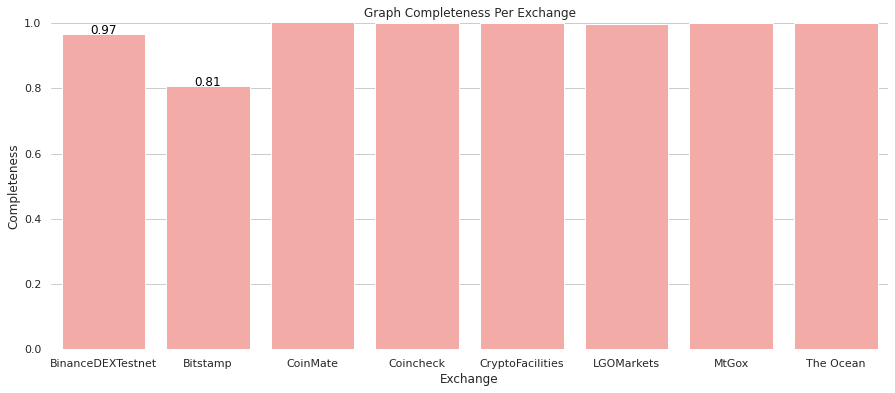

In [ ]:
# In this cell, we take a closer look at the most graph complete exchanges

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
most_complete = graph_completeness.where(
    graph_completeness >= 0.80).dropna()

# Plot the total crashes
g= sns.barplot(x= most_complete.index,
               y= most_complete.values,
               color= 'r')

# Add axis labels
ax.set(title= 'Graph Completeness Per Exchange',
       ylabel="Completeness",
       xlabel="Exchange",
       ylim= (0,1))
g.set_xticklabels(labels= most_complete.index)

# Add bar measurements
for i in range(2):
    g.text(i,
           most_complete[i],
           s= round(most_complete[i], 2),
           color='black',
           ha="center")
    
sns.despine(left=True, bottom=True)

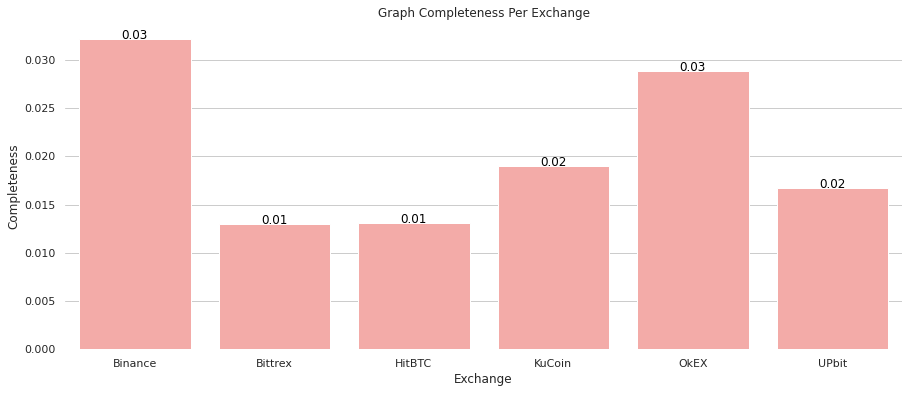

In [ ]:
# In this cell, we take a closer look at the exchanges that offer the most
# exchange rate data per day

# Set theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Set the color code
sns.set_color_codes("pastel")

# Structure the data
seven_largest_most_complete = graph_completeness.filter(
    items=['Binance',
           'Bittrex',
           'HitBTC',
           'KuCoin',
           'OkEX',
           'UPbit',
           'YoBit'])

# Plot the total crashes
g= sns.barplot(x= seven_largest_most_complete.index,
               y= seven_largest_most_complete.values,
               color= 'r')

# Add axis labels
ax.set(title= 'Graph Completeness Per Exchange',
       ylabel="Completeness",
       xlabel="Exchange")
g.set_xticklabels(labels= seven_largest_most_complete.index)

# Add bar measurements
for i in range(len(seven_largest_most_complete)):
    g.text(i,
           seven_largest_most_complete[i],
           s= round(seven_largest_most_complete[i], 2),
           color='black',
           ha="center")
    
sns.despine(left=True, bottom=True)

These graphs point out interesting holes in our data which we may want to keep in mind as complete further analysis. Now that we have a sense of our graph data, we will develop functions to connstruct graphs from our data and search for arbitrage opportunities within those graphs.

### Graph Representation and Arbitrage Functions

In order to look for arbitrage, we first have to define methods that will (1) convert our data into a form representable by a graph and (2) identify shorter paths between currencies than given in our data set.

To accomplish these goals, we first transformed our data and then used the Bellman-Ford Algorithm, which identifies the shortest path from a given source node to all other nodes and indicates if there exists a negative edge weight path in our graph. 

Specifically, we converted our data on exchange rates into a dataframe representing every edge between two cryptocurrencies. Then, we transformed each exchange rate, or the weight of an edge, by taking the negative log of each weight. The reason for this is because in order for arbitrage to occur, we need to find a path with weights such that all weights multiplied together will be greater than one. Logically, this makes sense, as each exchange rate indicates how much quote currency you can buy for 1 base currency. If you start with 1 unit of base currency and undergo a series of exchanges, in a perfectly efficient market, you should have the equivalent of 1 base currency after every trade.
      
      For a path with n trades, arbitrage occurs when
      w_1 * w_2 * ... * w_n > 1
      
      We can re-express this inequality as follows:
      log(w_1 * w_2 * ... * w_n) > log(1)
      log(w_1 * w_2 * ... * w_n) > 0
      -log(w_1 * w_2 * ... * w_n) < 0

      A negative edge-weight cycle:
      (-log(w_1) + (-log(w_2)) + ... + (-log(w_n)) < 0

By transforming our exchange data, we can now effectively use the Bellman-Ford Algorithm to detect arbitrage opportunities. Wherever there exists a negative edge weight cycle, there must, equivalently exist a path such that the product of its edges is greater than one, as we have shown directly above.

In [10]:
def make_graph(prices_df, date, exchange) :
  """Constructs a DataFrame of all edges in a graph representing cryptocurrency
     trades for a given exchange on a specified date

    Parameters
    ----------
    prices_df : DataFrame
        Cryptocurrency data containing date, exchange name, base asset,
        quote asset, and exchange rate
    date : str
        The date for which the algorithm should return exchange rates
    exchange : str
        The name of the exchange for which the algorithm should return exchange
        rates

    Returns
    -------
    Dataframe
        a DataFrame of edges in the graph of cryptocurrency trades
    """

  if exchange is not None : # This path occurs when there is a specified
                            # exchange
    
    # Extract the data points in the data frame with the desired date and
    # exchange
    graph = prices_df.loc[(prices_df['date'] == date) &
                          (prices_df['exchange_name'] == exchange)]

    # Format the graph dataframe
    graph = graph[['base_asset', 'quote_asset', 'vwap']].\
    rename({'base_asset': 'from_node',
            'quote_asset': 'to_node',
            'vwap': 'exchange_rate'},
           axis='columns').\
           reset_index(drop = True)

  else : # This path occurs when there is no given exchange parameter
    
    # Extract the data points in the data frame with the desired date
    graph = prices_df.loc[(prices_df['date'] == date)]

    # Format of the graph dataframe
    graph = graph[['base_asset', 'quote_asset', 'exchange', 'vwap']].\
    rename({'base_asset': 'from_node',
            'quote_asset': 'to_node',
            'vwap': 'exchange_rate'},
           axis='columns').\
           reset_index(drop = True)
  
    # Add additional edges to fill in some gaps in our data.
    # This step allows us to trade between exchanges.
    # Note that this analysis assumes that an investor would incur no
    # transaction costs when switching between exchanges.
    exchanges = graph['exchange'].unique().tolist()
    currencies = graph['from_node'].append(graph['to_node']).unique().tolist()
    
    # Create a new DataFrame with the edges we need to connect different
    # exchanges
    rows = []
    for exchange in exchanges :
      for currency in currencies :
        rows.append([currency, currency, exchange, 1])
  
    between_exchanges_df = pd.DataFrame(rows, columns=['from_node',
                                                       'to_node',
                                                       'exchange',
                                                       'exchange_rate'])
    
    # Append the newly created edges to our existing graph
    graph = graph.append(between_exchanges_df)
  
    # Identify the location/exchange of each currency node
    graph.loc[:,'from_node'] = graph[['from_node', 'exchange']].\
    agg('_'.join, axis=1)
    graph.loc[:,'to_node'] = graph[['to_node', 'exchange']].\
    agg('_'.join, axis=1)

    # Finalize the format of the graph dataframe
    graph = graph[['from_node',
                   'to_node',
                   'exchange_rate']].\
                   reset_index(drop = True)
            
  return graph

In [11]:
def arbitrage(df, date, exchange= None) :
  """Prints all possible arbitrage paths on a given date (and exchange)

    Parameters
    ----------
    prices_df : DataFrame
        Cryptocurrency data containing date, exchange name, base asset,
        quote asset, and exchange rate
    date : str
        The date at which the algorithm should search for arbitrage
        opportunities
    exchange : str, optional
        The name of the exchange in which the algorithm should search for
        arbitrage opportunities. If not specified, the algorithm will search
        for all arbitrage opportunities on the given day, between exchanges.
        (default is None)

    Returns
    -------
    None
    """
  arbitrage = False
  graph = make_graph(df, date, exchange)

  # Take the negative log of exchange_rate (reason explained in section header)
  graph.loc[:,'exchange_rate'] = graph['exchange_rate'].apply(
      lambda x : -np.log(x))

  # In some cases, we have data that cannot be cleaned. For example, the Deribit
  # exchange on 2019-03-29 has odd symbols (BTC10JUL2010000C) that cannot be
  # resolved to two currencies using the asset_codes we have in this data. Since
  # we cannnot be sure of what two currencies may be traded with this code, we
  # must drop the date and exchange combination from our analysis.
  
  if len(graph) == 0 :
    print("{:<10s} presents no opportunity for arbitrage on "\
          .format(exchange) + date[:10])
    print('-' * 65)
    return

  ### Bellman-Ford Algorithm

  ## Step 1: Initialize dictionaries to track values
  
  # The list of all currencies traded in the graph (number of nodes N)
  currencies = graph['from_node'].append(graph['to_node']).unique().tolist()
  
  dist = {} # Distance Dict
  parent = {} # Parent or Predecessor Dict
  
  # Set distances from src to all other nodes as INFINITE.
  for currency in currencies :
    dist[currency] = float("Inf")

  dist[graph['from_node'][0]] = 0 # Set starting node distance to 0
  
  # Set parents of all nodes as N/A to indicate no assigned parent.
  for currency in currencies :
    parent[currency] = 'N/A'

  ## Step 2: Relax all edges |N| - 1 times.
  for x in range(len(currencies) - 1):
    for ind in graph.index:
        if dist[graph['to_node'][ind]] > dist[graph['from_node'][ind]] +\
         graph.loc[(graph['from_node'] == graph['from_node'][ind]) &
                   (graph['to_node'] == graph['to_node'][ind]),
                   'exchange_rate'].iloc[0]:
                   dist[graph['to_node'][ind]] =\
                   dist[graph['from_node'][ind]] +\
                   graph.loc[(graph['from_node'] == graph['from_node'][ind]) &
                             (graph['to_node'] == graph['to_node'][ind]),
                             'exchange_rate'].iloc[0]
                   parent[graph['to_node'][ind]] = graph['from_node'][ind]

  ## Step 3: Check for a negative edge weight cycle.
  for ind in graph.index:
    if dist[graph['to_node'][ind]] > dist[graph['from_node'][ind]] +\
    graph.loc[(graph['from_node'] == graph['from_node'][ind]) &
              (graph['to_node'] == graph['to_node'][ind]),
              'exchange_rate'].iloc[0]:
              arbitrage = True
              from_node = graph['from_node'][ind]
              to_node = graph['to_node'][ind]
              path = [to_node, from_node]
              while parent[from_node] not in path and\
               parent[from_node] is not 'N/A':
                path.append(parent[from_node])
                from_node = parent[from_node]
              path.append(parent[from_node])
              path = path[::-1]
              print("{:<5s} arbitrage opportunity on ".format(exchange) +\
                    date[:10] +\
                    ":\nTrade " +\
                    " --> ".join(path))
              profit = 1
              for i in range(len(path) - 1) :
                weight = graph.loc[(graph['from_node'] == path[i]) &
                                   (graph['to_node'] == path[i + 1]),
                                   'exchange_rate'].iloc[0]
                weight = np.exp(weight * -1)
                profit = profit * weight
              if (path[0] == path[-1]) :
                direct = 1
              else :
                direct = np.exp(graph.\
                loc[(graph['from_node'] == path[0]) &
                    (graph['to_node'] == path[-1]),
                    'exchange_rate'].iloc[0] * -1)
              profit = profit - direct
              print("Profit " +
                    str(profit) +
                    " " +
                    path[-1])
              print('-' * 65)
  if arbitrage is False :
    print("{:<10s} presents no opportunity for arbitrage on ".\
          format(exchange) + date[:10])
    print('-' * 65)
  return

### Searching for Arbitrage

With our functions defined, we can now search for real examples of arbitrage in our dataset. We can use this cell to search for arbitrage on any exchange at any date.

In [ ]:
# Example Arbitrage Opportunity on OkCoin on March 29, 2019
# Bittrex and EXX two exchanges that seemed to most frequently
# present arbitrage opportunities
date = '2019-03-29'
exchange = 'OkCoin'
arbitrage(cleaned_daily_price_df, date, exchange)

OkCoin arbitrage opportunity on 2019-03-29:
Trade BTC --> USD --> TUSD --> ETH --> BTC
Profit 0.004662921758318728 BTC
-----------------------------------------------------------------
OkCoin arbitrage opportunity on 2019-03-29:
Trade USD --> TUSD --> BTC --> USD
Profit 0.00426844443492147 USD
-----------------------------------------------------------------


This cell contains a for-loop which searches for arbitrage between all combinations of exchange and date in our dataset. Due to an interest of time, we were, unfortunately, not able to run the algorithm on the entire dataset. However, after running this loop for the dates of March 29, 2019 and April 6, 2019, we successfully found several arbitrage opportunities in the data.

* OkCoin on 2019-03-29
* EXX from March 30th to April 6th, 2019 (excluding April 5th)
* Bittrex from March 31st to April 6th, 2019 (excluding April 1st)

In [ ]:
# Run this cell to find all the examples of arbitrage opportunity in our
# data set for every date and exchange
try:
  for date in daily_price_df['date'].unique().astype(str).tolist() :
    for exchange in daily_price_df['exchange_name'].unique().tolist() :
      if (len(daily_price_df.loc[(daily_price_df.date == date)
      & (daily_price_df.exchange_name == exchange),:]) == 0) : continue
      arbitrage(cleaned_daily_price_df, date, exchange)
except KeyboardInterrupt:
    quit(0)     

AnyBits    presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
ACX        presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
Allcoin    presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
Bibox      presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
BeQuant    presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
bitFlyer   presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
Bitfinex   presents no opportunity for arbitrage on 2019-03-29
-----------------------------------------------------------------
BitForex   presents no opportunity for arbitrage on 2019-03-29
----------------------------------

The following cell will output arbitrage paths on a specified date, between exchanges. Due to the length of our data and time contraints, we do not dive into the analysis of arbitrage opportunities between exchanges, but it is certainly an interesting item to look at in a future study.

In [12]:
# Use this cell to explore arbitrage between exchanges
# (assuming no transaction costs when switching between exchanges)
try:
  arbitrage(cleaned_daily_price_df, '2019-03-30')
except KeyboardInterrupt:
  quit(0)    

In summary of our analysis, we found that we were incorrect about expecting to see the greatest number of arbitrage opportunities in the largest exchanges. In other words, there does not seem to be a direct tie between the structure of the graph representation of an exchange and pricing inefficiency/arbitrage. In the next section of our project, *Modeling*, we have the goal of better understanding what factors can best predict exchange rates and, therefore, arbitrage in exchanges.

## Section 4: Modeling

### Modeling Introduction
Professional data scientists struggle to predict exact price changes in commodities, it is nearly impossible to do well with the current data analytics techniques that exist.Before trying to tackle this seemingly impossible problem, let's first consider a simplified version: on any given day, will Bitcoin's U.S. Dollar value go up or down? Modeling the answers to binary questions like this can be done using classification algorithms. In CIS545, we have discussed a few techniques that can potentially be used for classification. K-means, decision-trees, random forests, neural networks, and logistic-regression immediately come to mind. As it would be difficult/messy to attempt to cluster time-series data with one point per day, k-means classification is probably not a good fit. Decision trees and random forest are possible, but it is ultimately the wrong decision for a few reasons. First, decision trees assume that all terms in the tree are interactive which isn't necessarily the case. Another thing, random forest classifiers as built in python do not provide ideal methods for feature selection with such a high number of potential predictors. Once lag variables are involved, it will be difficult to view decision trees and clearly figure out what predictors to keep. Neural networks for classification and logistic regression are both interesting possibilities, let's first build the latter as it is more simply implemented. 


### Logistic Regression
Logistic Regression is linear-based model used commonly to classify data into some number of categories. In this section, we will attemp to build a Logistic Regression model that accurately determines whether or not Bitcoin will increase in value on a given day. 

In [ ]:
# create a dataframe to use in our logistic regression
logistic_reg_df = cleaned_daily_price_df.copy()

# we will be analyzing bitcoin's USD value, so we only want information 
# regarding this exchange rate
logistic_reg_df = logistic_reg_df[logistic_reg_df.quote_asset == 'USD']
logistic_reg_df = logistic_reg_df[logistic_reg_df.base_asset == 'BTC']

# we will try to build our model based on data that is in chronological order
logistic_reg_df = logistic_reg_df.sort_values(by= 'date')

# we only look to predict closing value, these other values will provide the 
# model with unfair information that comes from the same day.
logistic_reg_df = logistic_reg_df.drop(columns= ['kaiko_legacy_slug', 'open',
                                                 'high', 'low', 'vwap'])

# get a copy of non-cryptocurrency data
non_crypto_lr_df = non_crypto_df.copy()

# convert the logistic regression dataframe's date feature to a string so that 
# it can be merged with the non-cryptocurrency by date.
logistic_reg_df['date'] = logistic_reg_df['date'].apply(
    lambda x: x.strftime('%Y-%m-%d'))
# merge bitcoin data with non-cryptocurrency data
logistic_reg_df = logistic_reg_df.merge(
    non_crypto_lr_df, on= 'date', how='inner')
# convert the logistic regression dataframe's date feature back to a datetime
logistic_reg_df['date'] = logistic_reg_df['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

# to remove a few instances of duplicate dates in the data frame, drop 
# duplicates of dates and keep the first instance
logistic_reg_df = logistic_reg_df.drop_duplicates(subset='date', keep='first')
# reset the index of the logistic regression datafreame after the merge
logistic_reg_df = logistic_reg_df.reset_index(drop=True)

Brief note: unfortunately, due to the fact that most cryptocurrencies are relatively new and our dataset is slightly spotty, we will not have enough data to use other currencies behaviors as predictors. As cryptocurrency continues to grow, this would be an interesting project to revisit a few years down the line with a similar, updated dataset. 

Now that we have merged the non-cryptocurrency data with the Bitcoin data, let's shift this data so we can use past values of financial indicators to predict future Bitcoin prices. We will create lag variables for the seven days previous as well as another lag variable for a month before a given date. 

In [ ]:
# In this cell, we will use the shift function to create lagged variables for 
# all our predictors. We create lags for every day prior to the day we are 
# considering, as well as a month (30 days) previous.

# LAGS for Closing Rate of BTC to USD
logistic_reg_df['close_1_day_ago'] = logistic_reg_df.close.shift(1)
logistic_reg_df['close_2_days_ago'] = logistic_reg_df.close.shift(2)
logistic_reg_df['close_3_days_ago'] = logistic_reg_df.close.shift(3)
logistic_reg_df['close_4_days_ago'] = logistic_reg_df.close.shift(4)
logistic_reg_df['close_5_days_ago'] = logistic_reg_df.close.shift(5)
logistic_reg_df['close_6_days_ago'] = logistic_reg_df.close.shift(6)
logistic_reg_df['close_7_days_ago'] = logistic_reg_df.close.shift(7)
logistic_reg_df['close_1_month_ago'] = logistic_reg_df.close.shift(30)


# LAGS for WTI oil price
logistic_reg_df['oil_1_day_ago'] = logistic_reg_df.oil_wti_price.shift(1)
logistic_reg_df['oil_2_days_ago'] = logistic_reg_df.oil_wti_price.shift(2)
logistic_reg_df['oil_3_days_ago'] = logistic_reg_df.oil_wti_price.shift(3)
logistic_reg_df['oil_4_days_ago'] = logistic_reg_df.oil_wti_price.shift(4)
logistic_reg_df['oil_5_days_ago'] = logistic_reg_df.oil_wti_price.shift(5)
logistic_reg_df['oil_6_days_ago'] = logistic_reg_df.oil_wti_price.shift(6)
logistic_reg_df['oil_7_days_ago'] = logistic_reg_df.oil_wti_price.shift(7)
logistic_reg_df['oil_1_month_ago'] = logistic_reg_df.oil_wti_price.shift(30)

# LAGS for gold price
logistic_reg_df['gold_1_day_ago'] = logistic_reg_df.gold_price.shift(1)
logistic_reg_df['gold_2_days_ago'] = logistic_reg_df.gold_price.shift(2)
logistic_reg_df['gold_3_days_ago'] = logistic_reg_df.gold_price.shift(3)
logistic_reg_df['gold_4_days_ago'] = logistic_reg_df.gold_price.shift(4)
logistic_reg_df['gold_5_days_ago'] = logistic_reg_df.gold_price.shift(5)
logistic_reg_df['gold_6_days_ago'] = logistic_reg_df.gold_price.shift(6)
logistic_reg_df['gold_7_days_ago'] = logistic_reg_df.gold_price.shift(7)
logistic_reg_df['gold_1_month_ago'] = logistic_reg_df.gold_price.shift(30)

# LAGS for LIBOR 3 month interest rate
logistic_reg_df['libor_1_day_ago'] = logistic_reg_df.libor_3mo.shift(1)
logistic_reg_df['libor_2_days_ago'] = logistic_reg_df.libor_3mo.shift(2)
logistic_reg_df['libor_3_days_ago'] = logistic_reg_df.libor_3mo.shift(3)
logistic_reg_df['libor_4_days_ago'] = logistic_reg_df.libor_3mo.shift(4)
logistic_reg_df['libor_5_days_ago'] = logistic_reg_df.libor_3mo.shift(5)
logistic_reg_df['libor_6_days_ago'] = logistic_reg_df.libor_3mo.shift(6)
logistic_reg_df['libor_7_days_ago'] = logistic_reg_df.libor_3mo.shift(7)
logistic_reg_df['libor_1_month_ago'] = logistic_reg_df.libor_3mo.shift(30)

# LAGS for equity market uncertainty index
logistic_reg_df['uncertainty_1_day_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(1)
logistic_reg_df['uncertainty_2_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(2)
logistic_reg_df['uncertainty_3_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(3)
logistic_reg_df['uncertainty_4_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(4)
logistic_reg_df['uncertainty_5_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(5)
logistic_reg_df['uncertainty_6_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(6)
logistic_reg_df['uncertainty_7_days_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(7)
logistic_reg_df['uncertainty_1_month_ago'] = logistic_reg_df.\
equity_market_uncert_index.shift(30)

# LAGS for CAPM Market Rate of Return (rm)
logistic_reg_df['rm_1_day_ago'] = logistic_reg_df.rm.shift(1)
logistic_reg_df['rm_2_days_ago'] = logistic_reg_df.rm.shift(2)
logistic_reg_df['rm_3_days_ago'] = logistic_reg_df.rm.shift(3)
logistic_reg_df['rm_4_days_ago'] = logistic_reg_df.rm.shift(4)
logistic_reg_df['rm_5_days_ago'] = logistic_reg_df.rm.shift(5)
logistic_reg_df['rm_6_days_ago'] = logistic_reg_df.rm.shift(6)
logistic_reg_df['rm_7_days_ago'] = logistic_reg_df.rm.shift(7)
logistic_reg_df['rm_1_month_ago'] = logistic_reg_df.rm.shift(30)

# LAGS for CAPM Risk Free Rate of Return (rf)
logistic_reg_df['rf_1_day_ago'] = logistic_reg_df.rf.shift(1)
logistic_reg_df['rf_2_days_ago'] = logistic_reg_df.rf.shift(2)
logistic_reg_df['rf_3_days_ago'] = logistic_reg_df.rf.shift(3)
logistic_reg_df['rf_4_days_ago'] = logistic_reg_df.rf.shift(4)
logistic_reg_df['rf_5_days_ago'] = logistic_reg_df.rf.shift(5)
logistic_reg_df['rf_6_days_ago'] = logistic_reg_df.rf.shift(6)
logistic_reg_df['rf_7_days_ago'] = logistic_reg_df.rf.shift(7)
logistic_reg_df['rf_1_month_ago'] = logistic_reg_df.rf.shift(30)

# LAGS for French Stock Pricing Model Small Minus Big (smb)
logistic_reg_df['smb_1_day_ago'] = logistic_reg_df.smb.shift(1)
logistic_reg_df['smb_2_days_ago'] = logistic_reg_df.smb.shift(2)
logistic_reg_df['smb_3_days_ago'] = logistic_reg_df.smb.shift(3)
logistic_reg_df['smb_4_days_ago'] = logistic_reg_df.smb.shift(4)
logistic_reg_df['smb_5_days_ago'] = logistic_reg_df.smb.shift(5)
logistic_reg_df['smb_6_days_ago'] = logistic_reg_df.smb.shift(6)
logistic_reg_df['smb_7_days_ago'] = logistic_reg_df.smb.shift(7)
logistic_reg_df['smb_1_month_ago'] = logistic_reg_df.smb.shift(30)

# LAGS for French Stock Pricing Model High Minus Low (hml)
logistic_reg_df['hml_1_day_ago'] = logistic_reg_df.hml.shift(1)
logistic_reg_df['hml_2_days_ago'] = logistic_reg_df.hml.shift(2)
logistic_reg_df['hml_3_days_ago'] = logistic_reg_df.hml.shift(3)
logistic_reg_df['hml_4_days_ago'] = logistic_reg_df.hml.shift(4)
logistic_reg_df['hml_5_days_ago'] = logistic_reg_df.hml.shift(5)
logistic_reg_df['hml_6_days_ago'] = logistic_reg_df.hml.shift(6)
logistic_reg_df['hml_7_days_ago'] = logistic_reg_df.hml.shift(7)
logistic_reg_df['hml_1_month_ago'] = logistic_reg_df.hml.shift(30)

# create a binary variable for confirmation that confirms whether or not 
# the price of bitcoin increased from the previous day
logistic_reg_df['increased'] = 0
logistic_reg_df['increased'] = np.where((logistic_reg_df.close > 
                                         logistic_reg_df.close_1_day_ago), 
                                        1 ,logistic_reg_df.increased)

# adjust dates so there are no NA values from lag
logistic_reg_df = logistic_reg_df.dropna()
# reset the index of the dataframe again after alterations
logistic_reg_df = logistic_reg_df.reset_index(drop=True)

#drop current values of indicators so they are not used for prediction
#clearly it would not make sense to predict crypto movement with data
#from the same day
logistic_reg_df = logistic_reg_df.drop(columns=['oil_wti_price', 'gold_price',
                              'libor_3mo', 'equity_market_uncert_index', 'rm', 
                              'rf', 'hml', 'smb'])

Now that our data is completely in order, let's quickly look at a count plot to determine the number of days the value of Bitcoin in U.S. Dollars increased/decreased. 

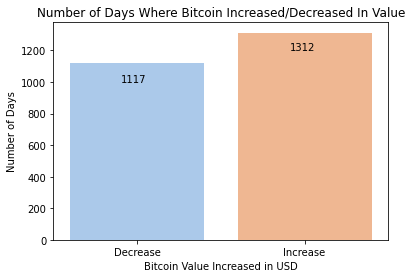

In [ ]:
# create a countplot of the number of increases and decreases in bitcoin price
# in our dataset
fig, ax = plt.subplots()
sns.countplot(x='increased', data=logistic_reg_df, palette='pastel')

# create x-label
plt.xlabel('Bitcoin Value Increased in USD')
# create y-label
plt.ylabel('Number of Days')
# create title
plt.title('Number of Days Where Bitcoin Increased/Decreased In Value')
# create new x-labels to replace the default binary labels
labels = ['Decrease', 'Increase']

# rename regression classes 
ax.set_xticklabels(labels)
# annotate the number of decreased in the bar graph
ax.annotate(logistic_reg_df.increased.isin([0]).sum(), (-.1, 1000))
# annotate the number of increased in the bar graph
ax.annotate(len(logistic_reg_df) - logistic_reg_df.increased.isin([0]).sum(),
            (.91, 1200))
plt.show() # show plot

It seems to be fairly balanced between increases and decreases with increases occuring on approximately 54.01% of days and decreases occuring on approximately 45.99% of days. 

Now that we have compiled and examined our data, let's begin to build our model by splitting into test and train data based on what we are attempting to predict. StatsModels logistic regression library can sometimes have difficulty interepting non-numeric values in training data, so we will drop columns such as exchange name before splitting just to be careful. We opted to use StatsModel rather than SciKit learn because the visualization of statistical figures regarding the regression output in a cleaner, more visually appealing format. 

In [ ]:
# choose values for logistic regression 
# we kept all possible predictors that were not categorical
x_vals = logistic_reg_df.drop(columns=['increased', 'exchange', 'symbol', 
                                       'exchange_name', 'base_asset',
                                       'quote_asset', 'date', 'count', 'volume',
                                       'close'])

# response values for logistic regression
y_vals = logistic_reg_df.increased

# split data into train and test for logistic regression
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals,
                                                    test_size= .2)

Now that we have split our data, lets build the logistic regression model. Quickly note that unlike SciKit Learn, StatsModels is able to regularize data as it is fitting the model without creating an external PCA. Our data is still being regularized, just within the method call instead of outside of it like we did in past homeworks. 

In [ ]:
# a single runtime warning to a single divide by zero prompted a warning
# the warning message cluttered the output of the logistic regression
warnings.filterwarnings('ignore')

# fit logistic regression model on x/y values chosen in previous cell
lr = sm.Logit(y_train, x_train).fit_regularized(max_iter = 1000)
# output statistical information regarding the regression such as p-values
print(lr.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6683110226016765
            Iterations: 280
            Function evaluations: 370
            Gradient evaluations: 280
                           Logit Regression Results                           
Dep. Variable:              increased   No. Observations:                 1943
Model:                          Logit   Df Residuals:                     1871
Method:                           MLE   Df Model:                           71
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.02988
Time:                        23:12:14   Log-Likelihood:                -1298.5
converged:                       True   LL-Null:                       -1338.5
Covariance Type:            nonrobust   LLR p-value:                    0.2174
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

Based on the output of this first naive model with nearly every predictor, clearly some predictors can afford to be removed. To create a more valuable logistic regression model, we will use backward elimination based on p-value on insignificant predictors. Note that we will not include the intermediate models brought about by the backward elimiation, we will only include our first and last model for simpilicity. Additionally, some predictors in intermediate models were removed despite being statistcally significant for a number of reasons. Some had coefficient of less than .0001, others had complex relationships with other predictors which skewed the model. After some analysis, we have arrived at the logistic regression model below. 

In [ ]:
# redefined x values for second logistic regression based on predictors chosen
# from backwards elimination
x_vals2 = x_vals[['close_1_day_ago', 'close_3_days_ago', 'gold_3_days_ago', 
                  'gold_4_days_ago', 'oil_3_days_ago', 'oil_4_days_ago',
                  'smb_1_month_ago']]

y_vals2 = logistic_reg_df.increased # response values clearly stay the same

Now that we have chosen the predictors to use in our model, let's split our data into train and test sets.

In [ ]:
# recreate train and test data based on our change in predictors
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_vals2, y_vals2,
                                                    test_size= .2)

Now that data is appropriately split and into a train set containing 80% of our data and and test set containing 20% of our data, let's run our improve logistic regression and fit our model.

In [ ]:
# a single runtime warning to a single divide by zero prompted a warning
# the warning message cluttered the output of the logistic regression
warnings.filterwarnings('ignore')

# fit new logistic regression model based on updates list of predictors
lr2 = sm.Logit(y_train2, x_train2).fit_regularized()
# output statistical information regarding new logistic regression
print(lr2.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6796876890813497
            Iterations: 17
            Function evaluations: 39
            Gradient evaluations: 17
                           Logit Regression Results                           
Dep. Variable:              increased   No. Observations:                 1943
Model:                          Logit   Df Residuals:                     1936
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 0.01501
Time:                        22:30:30   Log-Likelihood:                -1320.6
converged:                       True   LL-Null:                       -1340.8
Covariance Type:            nonrobust   LLR p-value:                 4.080e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

Now that we have created the model with which we are most satisfied given the data that we have, let's predict on the test data to determine our success. 

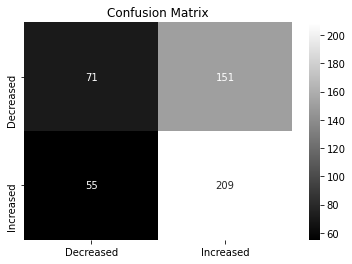

In [ ]:
# make predictions on test data based on our second logistic regression
predictions = lr2.predict(x_test2)

# create confusion matrix comparing predictions to actual outcomes
cfm = confusion_matrix(y_test2, predictions.round())

# create new labels to replace binary variables in visualization 
labels = ['Decreased', 'Increased']

# create x-label
plt.xlabel('Predicted')
# create y-label
plt.ylabel('Actual')
# create title
plt.title('Confusion Matrix')

# create actual confusion matrix as seaborn heatmap
ax = sns.heatmap(cfm, annot=True, cmap='gray', fmt='d')

# replace x and y tick labels
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# show confusion matrix
plt.show()

According to the confusion matrix above, our final logistic regression model predicted movement with about 57.6% accuracy. To put our model's quality into perspective, if you were to naively guess that Bitcoin increases in value everyday, you would only end up with 54.3% accuracy. A 3.3% difference in accuracy is pretty significant for financial data, so building and refining this logistic regression model was worthwhile. If predicting on the entire logistic regression data set, this naive accuracy would drop to 54.0%. While this is by no means an incredible model, it is a significant improvement from guessing and is fairly solid given the limited Bitcoin-specific data available. It is also worth noting that all predictors in this model are statistically significant if you allow a more generous $\alpha$ of 0.10, meaning that we can be 90% confident the results of this model did not occur randomly, a similar prediction would likely occur again. 



### Neural Network 

Now that we have tried our hand at logistic regression, let's see if we can improve our accuracy by building a more complex model using a neural network. Neural networks are compositions of learning elements called neurons that are connected in layers as a network, ultimately resulting in predictive outputs. Neural Networks are common in classification problems and can learn complex relationships between features. We will attempt to build one in order to predict whether Bitcoin will go up or down, same as above in our logistic regression. 

In [ ]:
# choose features to be used in recurrent neural network
rnn_vals = logistic_reg_df.drop(columns=['exchange', 'symbol', 
                                      'exchange_name', 'base_asset',
                                     'quote_asset', 'date', 'count', 'volume'
                                     , 'close', 'rf_1_day_ago', 'rf_2_days_ago', 
                                     'rf_3_days_ago', 'rf_4_days_ago', 
                                     'rf_5_days_ago', 'rf_6_days_ago', 
                                     'rf_7_days_ago', 'rf_1_month_ago', 
                                     'libor_1_day_ago', 'libor_2_days_ago',
                                     'libor_3_days_ago', 'libor_4_days_ago', 
                                     'libor_5_days_ago', 'libor_6_days_ago', 
                                     'libor_7_days_ago', 'libor_1_month_ago',
                                     'uncertainty_1_month_ago',
                                      'smb_4_days_ago', 
                                     'smb_5_days_ago', 'smb_6_days_ago',                                                                   
                                     ])

# split data into test and train 
# choose not to have a validation dataset due to limited data
rnn_train, rnn_test = train_test_split(rnn_vals, test_size = 0.2)

# set x train and test to all values excluding the response 
rnn_x_train = rnn_train.drop(columns=['increased'])
rnn_x_test = rnn_test.drop(columns=['increased'])

# set y train and test to be only the response
rnn_y_train = rnn_train.increased
rnn_y_test = rnn_test.increased

# for the commented out code below this, interestingly enough, the neural 
# network performed significantly better when data was left unscaled even 
# though it is typical to regularize/normalize
#scaler = StandardScaler()
#cnn_x_train = scaler.fit_transform(cnn_x_train)
#cnn_x_test = scaler.fit_transform(cnn_x_test)

# reshape x train and test to properly fit into the neural network
rnn_x_train = np.asarray(rnn_x_train).reshape(1943, 1, 52)
rnn_x_test = np.asarray(rnn_x_test).reshape(486, 1, 52)


Now that we have prepared our data as an input to a neural network, we can actually build one. The final neural network shown below is the product of extensive research as well as trial and error. We tried convolutional neural networks in hopes that their classification skills with images might be able to transer over. Ultimately, we found that recurrent neural networks are a better fit for time series data. We experiemented with different types of recurrent layers, GRU, LSTM, and SimpleRNN, ultimately finding the latter to work the best for our data. We tried networks with wide varieties of layer types and complexity, ultimately finding that the very simple RNN below learned our data the best. 

In [ ]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, SimpleRNN

# create a sequential neural network model
rnn_model = Sequential()

# add a simple recurrent layer to the model of size 2048 with dimensionality 
# of 2048
rnn_model.add(SimpleRNN(2048, input_shape=(1, 52)))
# add a dense output layer with a sigmoid activation function because we are 
# performing binary classification 
rnn_model.add(Dense(1, activation="sigmoid"))

# compile the model
# loss is binary crossentropy because this works best with binary classification
# optimzer was chosen to be adam after trial and error with other optimzers
rnn_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer= 'adam',
              metrics=['accuracy'])

# build recurrent neural network
rnn_model.build()

# print out summary of neural network layers
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 2048)              4302848   
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 4,304,897
Trainable params: 4,304,897
Non-trainable params: 0
_________________________________________________________________


Now that we have built and examined our Recurrent Neural Network, let's train it on our data. 

In [ ]:
# train the recurrent neural network on the model
# batch size was chosen through trial and error, as was the number of epochs
fitting = rnn_model.fit(rnn_x_train, rnn_y_train,
          batch_size=1200,
          epochs=25,
          verbose=1, 
          )

Epoch 1/25
2/2 [==============================] - 0s 127ms/step - loss: 0.7622 - accuracy: 0.4900
Epoch 2/25
2/2 [==============================] - 0s 126ms/step - loss: 0.8556 - accuracy: 0.5028
Epoch 3/25
2/2 [==============================] - 0s 125ms/step - loss: 0.7301 - accuracy: 0.5564
Epoch 4/25
2/2 [==============================] - 0s 139ms/step - loss: 0.7158 - accuracy: 0.5208
Epoch 5/25
2/2 [==============================] - 0s 130ms/step - loss: 0.6992 - accuracy: 0.5244
Epoch 6/25
2/2 [==============================] - 0s 139ms/step - loss: 0.6965 - accuracy: 0.5605
Epoch 7/25
2/2 [==============================] - 0s 130ms/step - loss: 0.6850 - accuracy: 0.5605
Epoch 8/25
2/2 [==============================] - 0s 131ms/step - loss: 0.6819 - accuracy: 0.5713
Epoch 9/25
2/2 [==============================] - 0s 125ms/step - loss: 0.6725 - accuracy: 0.5775
Epoch 10/25
2/2 [==============================] - 0s 134ms/step - loss: 0.6781 - accuracy: 0.5605
Epoch 11/25
2/2 [==

We were able to grow from as low as 49.00% accuracy in the 5th epoch to as high as 62.33% accuracy in the 22nd epoch, a fairly impressive margin of growth given the difficulty of predicting commodity movement. Additionally, note the appropriate decrease in loss over the epochs, reaching 0.8556 in the 2nd epoch and diminishing all the way to 0.6584 in the 25th.

Let's now use our test data to examine the success of our Recurrent Neural Network.

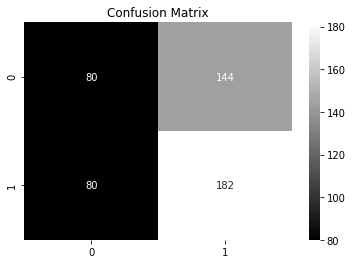

In [ ]:
# make predictions on test data based on our second logistic regression
rnn_predictions = rnn_model.predict(rnn_x_test)

# convert predictions from numpy 3d array to dataframe for confusion matrix 
# visualization
rnn_predictions = pd.DataFrame(rnn_predictions.flatten())

# create confusion matrix
cfm = confusion_matrix(rnn_y_test, rnn_predictions.round())

# create plot for confusion matrix
fig, ax = plt.subplots()

# create new labels to replace binary variables in visualization 
labels = ['Decreased', 'Increased']

# replace x and y tick labels
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# create x-label
plt.xlabel('Predicted')
# create y-label
plt.ylabel('Actual')
# create title
plt.title('Confusion Matrix')

# create actual confusion matrix as seaborn heatmap
sns.heatmap(cfm, annot=True, cmap='gray', fmt='d')
# show confusion matrix
plt.show()

Looking at the confusion matrix above, our neural network had significant problems with overfitting and only reached approximately 53.91% accuracy with the test data after reaching as high as 62.33% accuracy on test data. In testing, our neural network predicted at exactly the same rate of accuracy as if you had guessed that Bitcoin increased in value everyday on this test set, and worse than if you transfer this model test rate over to the entire data set, worse than if you had guessed that Bitcoin increased everyday (54% accuracy on all data).

From the information above, it is unfortunately made clear to us that we do not have enough data to build a successful neural network for cryptocurrency movement classfication. This lack of data is almost certainly the main cause of overfitting in our model. We could have kept in a drop layer we previously had to limit this overfitting,  but doing so significantly limited the amount that the model was able to learn and still predicted even worse on test data. Though we still feel recurrent neural networks could be extremely effective for commodity movement classification, it will probably be a while before this can successfully be used with cryptocurrency as this is a relatively new commodity and data is limited. 

Due to lack of data, we had more difficulty than expected predicting Bitcoin movement. Before moving on, quickly note that while our recurrent neural network performed approximately 3.69% worse on test data than the better logistic regression, depending on your financial goal, an argument could be made in favor of the neural network. For an investor who is extremly adverse to false positives which will cause them to lose money (i.e. model incorrectly predicts increase), the neural network model test has 7 less false positives than the logistic regression. Investors might prefer false positives to false negative as false negatives will only lead investors to miss out on potential profit but not actually lose any money. Though we feel the 3.69% accuracy is substantial enough to favor the logistic regression in this case, this is definitely a point worth considering.



### ARIMA Model
Despite our less than precise predictions of Bitcoin movement, out of sheer curiosity, let's still make an attempt to predict the actual price of Bitcoin. As Bitcoin (and cryptocurrency currency in general) can be classified as seasonal time-series data, our best bet is to forecast using ARIMA. 

The first thing we need should do when building an ARIMA model is test for stationarity using the Augmented Dickey Fuller test.

In [ ]:
# As we need different inputs than we used in the logistic regression,
# we need to create a new dataframe to run the ARIMA on. Similar to 
# our other models, we will consider USD to Bitcoin.
arima_df = cleaned_daily_price_df.copy()

# similar to other cases, we are only considering bitcoin dollar value.
arima_df = arima_df[arima_df.quote_asset == 'USD']
arima_df = arima_df[arima_df.base_asset == 'BTC']

# our model is a simple ARIMA model so we need only closing price and date.
arima_df = arima_df[['date', 'close']]

# again similar to other cases, drop the few rare instances of duplicate dates
arima_df = arima_df.drop_duplicates(subset='date', keep='first')

# order the data chronologically
arima_df = arima_df.sort_values(by='date')

# Prints Results for the ADF Test for Stationarity
print('Augmented Dickey Fuller Test Statistic:')
print(adfuller(arima_df.close)[0])
print('P-Value:')
print(adfuller(arima_df.close)[1])

Augmented Dickey Fuller Test Statistic:
-1.4261261403845733
P-Value:
0.5696888260872017


Since the P-Value is > 0.05, we can reject the null-hypothesis that our Bitcoin Data is stationary. Intuitively, this makes sense as we know Bitcoin has grown massively in the last decade but it is always good to confirm our assumptions. 

Similar to our previous two models, let's now split our data into train and test sets.

In [ ]:
# Split into Train and Test Data, allowing data to stay in order
arima_train, arima_test = train_test_split(arima_df, test_size=0.2, shuffle=False)

# reset index on train and test for convenience during visualization
arima_train = arima_train.reset_index(drop=True)
arima_test = arima_test.reset_index(drop=True)

Now that we've appropriately split our data 80/20 again, let's fit our ARIMA model to the train data. We want to consider the widest window of past prices possible, so we have chosen to set out range to 20 days. Though we would likely need longer to fit an ideal model, attempting to run StatsModels' ARIMA with a window of larger than 20 unfortunately took too long (> 2 hours).

In [ ]:
#Creates an Arima Model with Window Size 20 and fits the model to train data
arima_model = ARIMA(arima_train.close, order=(20,1,0))
arima_model_fit = arima_model.fit()

# Summary of Fit Model
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2903
Model:                ARIMA(20, 1, 0)   Log Likelihood              -19157.406
Method:                       css-mle   S.D. of innovations            177.673
Date:                Tue, 15 Dec 2020   AIC                          38358.812
Time:                        23:05:52   BIC                          38490.229
Sample:                             1   HQIC                         38406.162
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.3107      4.339      0.533      0.594      -6.194      10.815
ar.L1.D.close      0.0477      0.018      2.600      0.009       0.012       0.084
ar.L2.D.close     -0.0334      0.018

It looks like more of the lag variables in this ARIMA model are statistically significant than insignificant. Variation between coefficients is interesting to look at is it is a bit non-intuitive as to what variables were large and what variables were small. Looking at our AIC value of over 38,000, it is probably safe to assume this model does not fit the data well.

Let's test our data on a few differnt scales now to see how well it actually forecasts bitcoin's behavior. First we'll start by trying to predict the first three days after the train set.

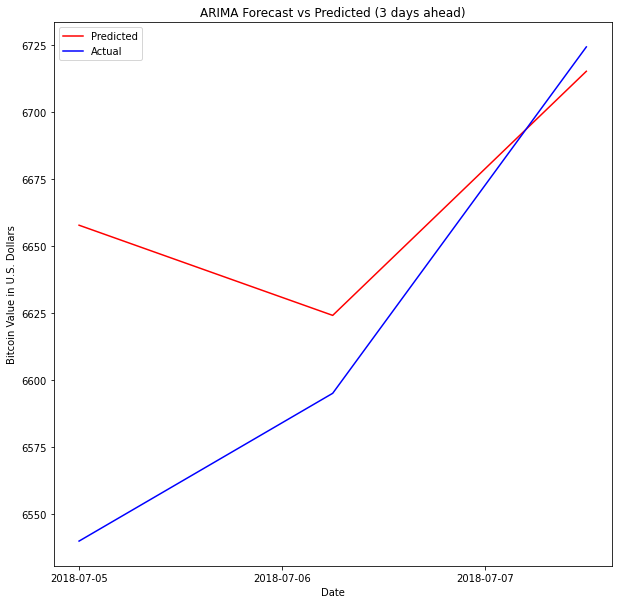

In [ ]:
# forecast bitcoin prices using the arima model and format predictions 
# appropiately
forecast = arima_model_fit.forecast(steps=3, alpha=0.05)[0]
forecast_df = pd.DataFrame(forecast, columns=['predicted_close'])
forecast_df['date'] = arima_test.date

# create plot
fig, ax = plt.subplots(figsize=(10, 10))

# project the first three days after train's actual values from test set
first_three_df = arima_test.head(3)

# plot predicted 
plt.plot(forecast_df['date'], forecast_df['predicted_close'], 
         'r-', label= 'Predicted')
# plot actual
plt.plot(first_three_df['date'], first_three_df['close'],
         'b-', label= 'Actual')

# plot title 
plt.title('ARIMA Forecast vs Predicted (3 days ahead)')
# plot x-label
plt.xlabel('Date')
# plot y-label
plt.ylabel('Bitcoin Value in U.S. Dollars')

# differentiate between predicted and actual
plt.legend()

# limit plot size to 3 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(3)) 

# adjust tick labels to the appropiate dates
# dummy 0 is put in to be placed in the bottom left corner of the plot
ax.set_xticklabels(['0', '2018-07-05', '2018-07-06', '2018-07-07'])

# show plot
plt.show()

Even in a small scope, our model forecast has some pretty error. Let's calculate the root mean square error below. 

In [ ]:
print('Three Day Root Mean Square Error:')
print(mean_squared_error(first_three_df.close, forecast_df.predicted_close, 
                         squared=False))

Root Mean Square Error:
70.35017262798645


Though Bitcoin is priced in the upper 6000's, a RSME of 70.35 when only forecasting three days ahead is pretty unimpressive. Clearly, the model will get worse as you project further in the future as it will rely less on true historical data and more on its own predictions. Let's look a week and a month ahead to see how much worse the model gets with wider scope.

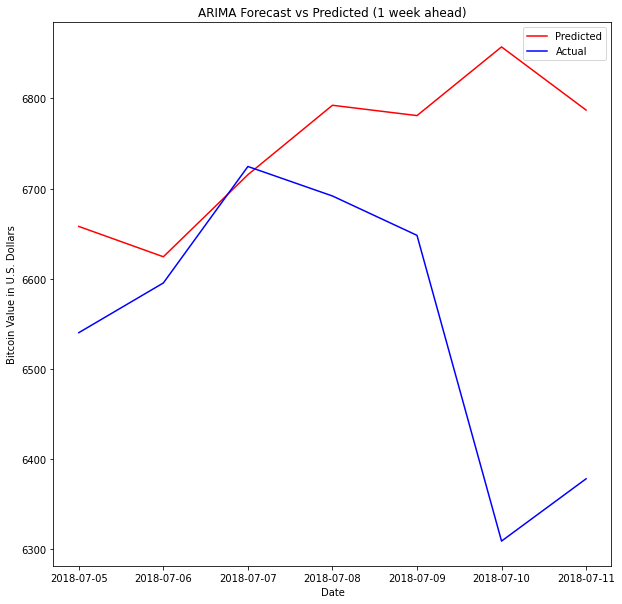

In [ ]:
# forecast bitcoin prices using the arima model and format predictions 
# appropiately
forecast = arima_model_fit.forecast(steps=7, alpha=0.05)[0]
forecast_df = pd.DataFrame(forecast, columns=['predicted_close'])
forecast_df['date'] = arima_test.date

# create plot
fig, ax = plt.subplots(figsize=(10, 10))

# project the first week after train's actual values from test set
first_week_df = arima_test.head(7)

# plot predicted 
plt.plot(forecast_df['date'], forecast_df['predicted_close'], 
         'r-', label= 'Predicted')
# plot actual
plt.plot(first_week_df['date'], first_week_df['close'],
         'b-', label= 'Actual')

# plot title 
plt.title('ARIMA Forecast vs Predicted (1 week ahead)')
# plot x-label
plt.xlabel('Date')
# plot y-label
plt.ylabel('Bitcoin Value in U.S. Dollars')

# differentiate between predicted and actual
plt.legend()

# limit plot size to 7 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(7)) 

# adjust tick labels to the appropiate dates
# dummy 0 is put in to be placed in the bottom left corner of the plot
ax.set_xticklabels(['0', '2018-07-05', '2018-07-06', '2018-07-07','2018-07-08',
                    '2018-07-09', '2018-07-10', '2018-07-11'])

# show plot
plt.show()

In [ ]:
print('One Week Root Mean Square Error:')
print(mean_squared_error(first_week_df.close, forecast_df.predicted_close, 
                         squared=False))

Root Mean Square Error:
270.36540385108196


The RMSE grows substantially by adding just four days to the forecast. Finally, let's check a month. 

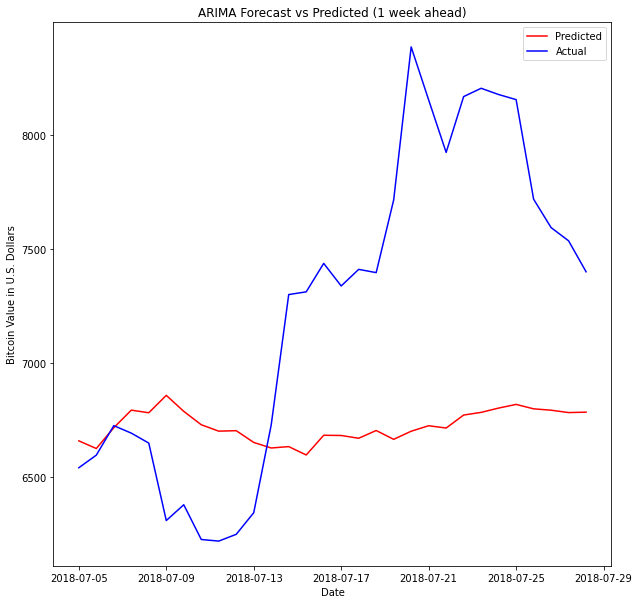

In [ ]:
# forecast bitcoin prices using the arima model and format predictions 
# appropiately
forecast = arima_model_fit.forecast(steps=30, alpha=0.05)[0]
forecast_df = pd.DataFrame(forecast, columns=['predicted_close'])
forecast_df['date'] = arima_test.date

# create plot
fig, ax = plt.subplots(figsize=(10, 10))

# project the first month after train's actual values from test set
first_month_df = arima_test.head(30)

# plot predicted 
plt.plot(forecast_df['date'], forecast_df['predicted_close'], 
         'r-', label= 'Predicted')
# plot actual
plt.plot(first_month_df['date'], first_month_df['close'],
         'b-', label= 'Actual')

# plot title 
plt.title('ARIMA Forecast vs Predicted (1 week ahead)')
# plot x-label
plt.xlabel('Date')
# plot y-label
plt.ylabel('Bitcoin Value in U.S. Dollars')

# differentiate between predicted and actual
plt.legend()

# limit plot size to 3 x-ticks
plt.gca().axes.xaxis.set_major_locator(plt.MaxNLocator(7)) 

# adjust tick labels to the appropiate dates
# dummy 0 is put in to be placed in the bottom left corner of the plot
ax.set_xticklabels(['0', '2018-07-05', '2018-07-09', '2018-07-13','2018-07-17',
                    '2018-07-21', '2018-07-25', '2018-07-29'])

# show plot
plt.show()

In [ ]:
print('One Month Root Mean Square Error:')
print(mean_squared_error(first_month_df.close, forecast_df.predicted_close, 
                         squared=False))

One Month Root Mean Square Error:
852.6183631066118


As you can see, the RMSE explodes as you increase the forecast size and visually, the ARIMA model does a pretty poor job of following Bitcoin's actual trends. 

### Modeling Conclusions
Ultimately, our models were less successful than we had hoped for when beginning the project. However, after completing the models and some additional research, we are still confident in our model choices and were suprised with how inaccurate cryptocurrency models generally are, even those built by professionals. Recurrent Neural Networks definitely have the potential to successfully model financial binary classification problems and ARIMA is still a great tool to use for forecasting financial time series data. Logistic Regression was okay for a problem like this (it actually performed best out of all our models) but in reality, the relationship between our features and response is likely not linear and thus, the performance capacity of a logistic regression is limited. 

The biggest problem in our modeling efforts was the lack of data available regarding the information we wanted to predict. Once we put together consistent data (overall cleaning, removal of useless information, consistency across exchange, etc.) regarding the price of Bitcoin in USD, our dataset of originally 4.5 million entries quickly dwindled down to a little less than 3,000. Models like ARIMA and especially Neural Networks require a significant amount of data to learn relationships and the amount of data needed to model cryptocurrencies just isn't available yet as these are still relatively new commodities. Despite our lack of data and somewhat underwhelming models, we still learned a significant amount about machine learning modeling through this project. After completing of the modeling section of this project, we feel we have a very strong understanding of how Logistic Regression, Neural Networks, and ARIMA are structured and how they work. Additionally, we take away very important experience in  feature selection and model-tuning. 

## Section 5: Description of Challenges

We encountered the first set of challenges in our project was when developing the arbitrage algorithms for our dataset. We were simply unsure of how we would identify arbitrage, and we would continuously ask ourselves whether we wanted to search for arbitrage within a single exchange, or whether it was realistic to search for arbitrage between multiple exchanges.

For the first challenge, we first attempted the algorithm based on knowledge that we had from other Finance and CIS courses. Namely, we knew that in order for arbitrage to occur, we needed to find a path of currencies whose product of their weights would multiply to 1. We also were aware of some shortest-path algorithms, such as the BFS and Dijkstra's algorithm. We began with a BFS algorithm that would multiply the exchange rate between two currencies at every traversal. However, our algorithm failed because it could not deal with negative weights.

Moving forward, we did research on how to solve our problems. Ultimately, we came across the Bellman-Ford algorithm, also covered in CIS 121, and used this algorithm to detect arbitrage opportunities because, unlike Dijkstra's, Bellman-Ford does not fail when implemented on graphs having negative weights. Now, using the Bellman-Ford algorithm, we had to change our approach in how we defined arbitrage in the graph. After doing some algebra, we discovered that we could, in fact, represent "the product of edges is greater than one" as "the sum of the negative log of edges is less than zero." After we made this transformation for the edges in our graphs, we could implement a standard Bellman-Ford algorithm to find the shortest path between all nodes in our graphs. Wherever we were able to find negative edge weight cycles, we could identify this path, and therefore, the arbitrage opportunity.

As for making the decision on whether we would check for arbitrage within or between exchanges, we decided to check for arbitrage specifically within exchanges in the interest of time. However, we did come up with a way to represent the switch between exchanges in a graph. Our method was to add edges of weight 1 between all identical currencies between exchanges. This allows our algorithm to traverse all exchanges and all exchange rates on a specified day.

Though we had some troubles with implementation of the arbitrage detection algorithm, our biggest issues came in the modeling portion of our project. 

The first, and smaller problem of the two we faced was feature selection. We attempted a number of feature selection processes, most of which did not make the final notebook. We tried decision trees, k best feature selection, analysis of ANOVA F-values, along with various python libraries that track feature importance. Though none of these thing were all that helpful, two other things helped us pick the features. First, we tuned our models with quite a bit of trial and error. We ran these models over and over with various combinations of input and kept track of what helped/hurt model accuracy. Secondly, and more importantly, we analyzed statistical characteristics of our predictors such as correlation, p-value, regression coefficients and used techniques such as backward elimination to remove useless predictors. Ultimately, we are confident we used the best features available to us in our data when constructing models, but it definitely took some time to find these features as they were not too intuitive. 

Our bigger problem in modeling, simply put, is that our data (and cryptocurrency data in general) is too small to learn accurately relationships between input and response. As mentioned previously in the modeling section of the project, attempting to build complex, accurate predictive with around 3,000 instances of data is extremely difficult. On top of this, Bitcoin and other cryptocurrencies have been very volatile in their lifespan as displayed in our graphs, making them even harder to predict than other financial data like stock prices. We did lots of research on the inner-workings of the various models we used as well as the models we chose not to use. Though it is possible that the structure of our models could improve (the Recurrent Neural Network could probably have performed slightly better with a significantly more complex structure), the potential accuracy for all three of our models is relatively low given the limits on our training data. This problem, unfortuntately, was out of our hands and can only be fixed as more data accumulates with time. 

## Section 6: Future Direction and Conclusion

Our project touches on a number of interesting data/computer science topics and ties them into potentially profitable financial topics. The future of this project could look a number of ways. 

For starters, though this would likely be difficult, we could like at combining the work we did in Section 3 regarding arbitrage with the work in Section 4 regarding predictive modeling. Though we are unsure how accurately it could be done as we did not pursue it, there definitely exists the possibility of predicting when and where arbitrage will occur. Through exploratory data analysis in Section 3, we were able to discover some patterns regarding what exchanges have arbitrage opportunities most frequently. If we were able to dig deeper into why these exchanges have abitrage more frequently than others, and maybe combine that information with other financial indicators, both those from this project and those outside of it, perhaps we could train a classification model like a logistic regression or a recurrent neural network to predict if a given exchange will or will not have an arbitrage opportunity. This information would be useful because if investors know that arbitrage is highly likely to occur on a particular day in a particular exchange, they can keep their eyes out for it and potentially generate profit with little effort. One potentially difficulty of this potential extension of our project is that the data is significantly imbalanced (i.e. arbitrage occurs much less often than not) but perhaps a more experienced data scientist could account for this more than we are able to. 

Another direction you could tangentially take data and information from this project lies further on the economics side of things. This project showed us that financial figures (LIBOR, WTI Oil Price, etc.) whose fluctuations correlate with stock market performance predictors (S&P 500) are not as great of indicators of cryptocurrency behavior. Perhaps with all this information regarding the behavior of various cryptocurrencies in various exchanges, someone with a stronger economic background could fill the void we discovered for a dominant cryptocurrency market index. Our belief is that someone could construct an index following a weighted system based on price and volume of currencies over time. Perhaps the exact formula for the index could even be constructed using unsupervised machine learning methods, such that coefficients are decided by learning cryptocurrency data so the market index is high when the market is doing well and the market index is low when the market is doing poorly. You could pick a list of the 500 biggest cryptocurrencies, for example, and keep creating models weighted by the values of these currencies until a formula for a satisfactory index is discovered. Though we do not have too many specific ideas on how this could be accomplished, it is an interesting idea to fill a gap we discovered in this project nonetheless. 

Since we had such difficulty creating accurate predictions for Bitcoin movement, there is another mathematical extension of this project that one could pursue. Cryptocurrency pricing is a bit of an enigma and we discovered through this project that there is speculation in academic circles that the pricing of cryptocurrencies is a random walk process. Perhaps someone interested in advanced stochastic statistics (Markov Chains and the like)or graph theory could use our exploratory data analysis and information from our predictive models to try to prove that Bitcoin pricing is or is not a random walk process. As we develop our statistics knowledge, perhaps we can revisit our findings from this project in the future to pursue this idea. 

Due to the limited accuracy of our predictive models, most future extensions of this project would require one to use our project somewhat tangentially like the three examples above. Overall, we enjoyed completing this project and found the information we gained throughout to be very insightful. We definitely completed some interesting exploratory data analysis, we were able to accomplish the difficult task of detecting arbitrage in cryptocurrency markets, and while our models performed worse than we had hoped, they are slightly better on average than the work of other scholars and data enthusiasts looking to perform similar analysis. This project really enforced our understanding of some difficult course material through applications, and we look forward to sharing our results.